In [1]:
import openmc
import openmc.deplete
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
import os
import time
import re
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone
from scipy.interpolate import griddata
from pearlsim.ml_utilities import *
from pearlsim.results_processing import read_core_flux
import pickle
from pearlsim.ml_model_wrappers import SingleModelWrapper, XSModelWrapper
from sklearn.neighbors import KNeighborsRegressor
import os.path
from pearlsim.get_fima import get_fima
from pearlsim.depletion_utilities import *
import subprocess
plt.rcParams.update({'font.size': 16})

2025-08-06 15:59:55.029484: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-06 15:59:55.046971: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-06 15:59:55.112132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-06 15:59:55.232281: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-06 15:59:55.269676: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-06 15:59:55.349283: I tensorflow/core/platform/cpu_feature_gu

In [2]:
current_features = pd.read_csv("training_data/current_data.csv.gz", index_col=0)
current_targets = pd.read_csv("training_data/current_targets.csv.gz", index_col=0)
flux_features = pd.read_csv("training_data/flux_data.csv.gz", index_col=0)
flux_targets = pd.read_csv("training_data/flux_targets.csv.gz", index_col=0)

In [3]:
display(current_features.iloc[-3:])
display(current_targets.iloc[-3:])
display(flux_features.iloc[-3:])
display(flux_targets.iloc[-3:])

,local_fima,local_graphite_frac,radius,height,energy,core_flux_at_energy,interpolated_power,interpolated_flux
56368,1.235415,0.0,91.4303,214.38,3.652,1.018627e+06,1.960387e-07,321360.664457
56369,1.235415,0.0,91.4303,214.38,5.369,3.213799e+05,1.960387e-07,321360.664457
56370,1.235415,0.0,91.4303,214.38,13.217,4.508021e+03,1.960387e-07,321360.664457


,current
56368,8.996190e+10
56369,2.872793e+10
56370,1.343440e+09


,1001<lib>,1002<lib>,1003<lib>,2003<lib>,2004<lib>,3006<lib>,3007<lib>,34074<lib>,34080<lib>,34082<lib>,...,942340,952380,962380,461000,581340,541220,561280,571340,430940,531220
35552,7.509750e-11,8.575004e-12,1.110095e-14,3.444696e-16,2.380960e-08,1.514021e-15,1.305389e-19,2.323580e-16,3.917312e-07,9.854358e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35553,7.509750e-11,8.575004e-12,1.110095e-14,3.444696e-16,2.380960e-08,1.514021e-15,1.305389e-19,2.323580e-16,3.917312e-07,9.854358e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35554,7.509750e-11,8.575004e-12,1.110095e-14,3.444696e-16,2.380960e-08,1.514021e-15,1.305389e-19,2.323580e-16,3.917312e-07,9.854358e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,flux
35552,3.782880e+13
35553,1.331062e+13
35554,5.271770e+12


# Data Standardization
Simple standardization is performed here along each column. I tried log-standardization, but it didn't seem to help with the current values.

In [4]:
train_split = 0.8
current_log_columns = ["core_flux_at_energy", "energy", "interpolated_power", "interpolated_flux"]
flux_log_columns = "all"

current_std_data = create_training_split(current_features, 
                                         current_targets, 
                                         train_split, 
                                         log_scale_features=current_log_columns,
                                         seed=42)
flux_std_data = create_training_split(flux_features, 
                                      flux_targets, 
                                      train_split, 
                                      log_scale_features=flux_log_columns,
                                      seed=42)

In [5]:
display(current_std_data["training_features"].iloc[-3:])
display(current_std_data["training_target"].iloc[-3:])
display(current_std_data["testing_features"].iloc[-3:])
display(current_std_data["testing_target"].iloc[-3:])

display(flux_std_data["training_features"].iloc[-3:])
display(flux_std_data["training_target"].iloc[-3:])
display(flux_std_data["testing_features"].iloc[-3:])
display(flux_std_data["testing_target"].iloc[-3:])

,local_fima,local_graphite_frac,radius,height,energy,core_flux_at_energy,interpolated_power,interpolated_flux
7523,0.544950,0.915594,-2.216881,0.718126,0.792758,-0.694453,-0.123143,0.633567
38598,0.241233,-0.825560,0.025991,-1.400134,-0.328602,0.429903,1.006406,0.588807
55015,-1.358350,-1.471792,0.065207,1.760074,1.188385,-1.123095,-0.473132,0.058373


,current
7523,-0.708054
38598,0.480071
55015,-1.299025


,local_fima,local_graphite_frac,radius,height,energy,core_flux_at_energy,interpolated_power,interpolated_flux
56349,-1.35777,-1.471792,0.457035,0.029109,-0.004237,-0.146831,-0.140165,0.214670
56354,-1.35777,-1.471792,0.457035,0.029109,0.702661,-0.602343,-0.140165,0.214587
56368,-1.35777,-1.471792,0.457035,0.029109,1.615395,-1.598619,-0.140165,-2.182927


,current
56349,-0.102050
56354,-0.699353
56368,-1.719684


,1001<lib>,1002<lib>,1003<lib>,2003<lib>,2004<lib>,3006<lib>,3007<lib>,34074<lib>,34080<lib>,34082<lib>,...,942340,952380,962380,461000,581340,541220,561280,571340,430940,531220
33874,0.352258,0.366342,0.376653,0.410426,0.345826,0.334247,0.327880,0.341507,0.344599,0.344660,...,-0.224313,-0.107838,-0.10783,-0.128655,-0.116916,-0.052098,-0.072733,-0.066127,-0.048203,-0.041964
9344,0.384463,0.348996,0.305821,0.317639,0.345710,0.339020,0.280529,0.313799,0.353021,0.353060,...,-0.224313,-0.107838,-0.10783,-0.128655,-0.116916,-0.052098,-0.072733,-0.066127,-0.048203,-0.041964
14141,0.262905,0.214670,0.256868,0.216635,0.339774,0.305523,0.239399,0.315883,0.353082,0.353119,...,-0.224313,-0.107838,-0.10783,-0.128655,-0.116916,-0.052098,-0.072733,-0.066127,-0.048203,-0.041964


,flux
33874,0.679502
9344,-1.294254
14141,0.067751


,1001<lib>,1002<lib>,1003<lib>,2003<lib>,2004<lib>,3006<lib>,3007<lib>,34074<lib>,34080<lib>,34082<lib>,...,942340,952380,962380,461000,581340,541220,561280,571340,430940,531220
35538,0.359813,0.371365,0.370493,0.404008,0.348624,0.339605,0.338347,0.345825,0.346147,0.346198,...,-0.224313,-0.107838,-0.10783,-0.128655,-0.116916,-0.052098,-0.072733,-0.066127,-0.048203,-0.041964
35540,0.359813,0.371365,0.370493,0.404008,0.348624,0.339605,0.338347,0.345825,0.346147,0.346198,...,-0.224313,-0.107838,-0.10783,-0.128655,-0.116916,-0.052098,-0.072733,-0.066127,-0.048203,-0.041964
35543,0.359813,0.371365,0.370493,0.404008,0.348624,0.339605,0.338347,0.345825,0.346147,0.346198,...,-0.224313,-0.107838,-0.10783,-0.128655,-0.116916,-0.052098,-0.072733,-0.066127,-0.048203,-0.041964


,flux
35538,-0.219025
35540,-0.371035
35543,-0.477781


# Model Training
I threw together a quick RFR model and got some results. You're free to change to any other type of model, as long as its something I can save and load into other modules. Things to try:
- Properly using cross validation
- Tuning the hyper parameters
- Trying a different model, probably a neural net

In [6]:
best_params = {'max_depth': 30, 
               'n_estimators': 1000, 
               'n_jobs': -1,} # Set to your number of cores
current_rfr_model = RandomForestRegressor(random_state=0)
current_rfr_model.set_params(**best_params)
current_rfr_model.fit(current_std_data["training_features"], current_std_data["training_target"])
current_rfr_score = current_rfr_model.score(current_std_data["testing_features"], current_std_data["testing_target"])
print(f"Current RFR score: {current_rfr_score}")

/global/home/users/ikolaja/.local/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Current RFR score: 0.9997202905040463


current_labels = current_std_data["testing_features"].columns
current_importances = current_rfr_model.feature_importances_

indices = np.argsort(current_importances)
top_importance_vals = current_importances[indices]
top_plot_features = current_labels[indices]

plt.title(f"Feature Importance for Current")
plt.xlabel("Feature")
plt.ylabel("Mean decrease in impurity")

plt.bar(top_plot_features, top_importance_vals, color ='maroon', 
        width = 0.4)
plt.xticks(rotation=30)


plt.tight_layout()
plt.savefig(f"training_data/current_top_features.png")
plt.show()


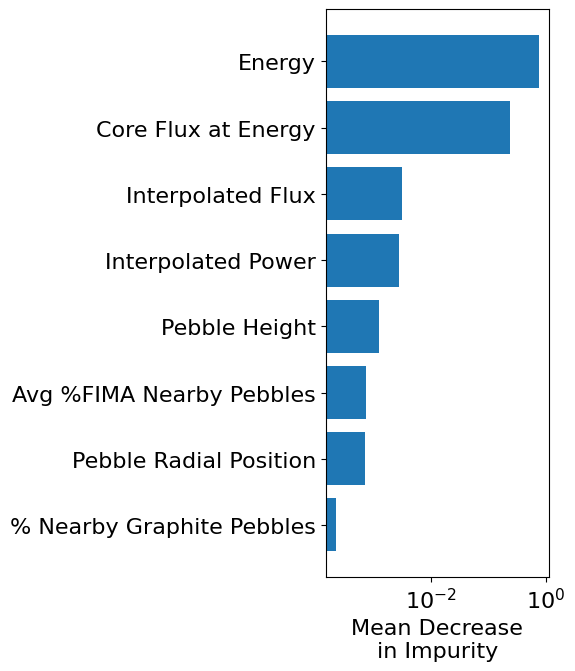

In [7]:
plt.rcParams.update({'font.size': 16})

feature_rename_key = {"energy": "Energy",
                      "core_flux_at_energy": "Core Flux at Energy",
                      "interpolated_flux": "Interpolated Flux",
                      "interpolated_power": "Interpolated Power",
                      "height": "Pebble Height",
                      "radius": "Pebble Radial Position",
                      "local_fima": "Avg %FIMA Nearby Pebbles",
                      "local_graphite_frac": "% Nearby Graphite Pebbles"}


current_labels_internal = current_std_data["testing_features"].columns
current_importances = current_rfr_model.feature_importances_

fig, ax = plt.subplots(ncols=1, figsize=(6,7))

sorted_indices = np.argsort(current_rfr_model.feature_importances_)
current_labels = current_std_data["testing_features"].rename(columns=feature_rename_key).columns[sorted_indices]
current_importances = current_rfr_model.feature_importances_[sorted_indices]
y_pos = np.arange(len(current_labels))

ax.barh(y_pos, current_importances, align='center')
ax.set_yticks(y_pos, labels=list(current_labels))
# o].invert_yaxis()  # labels read top-to-bottom
#ax.set_xlim(-0.1,1.1*max(current_importances))
ax.set_xlabel("Mean Decrease\nin Impurity")
ax.set_xscale("log")
fig.tight_layout()
plt.savefig("figures/hyperfidelity/current_feature_importance.png")
plt.show()

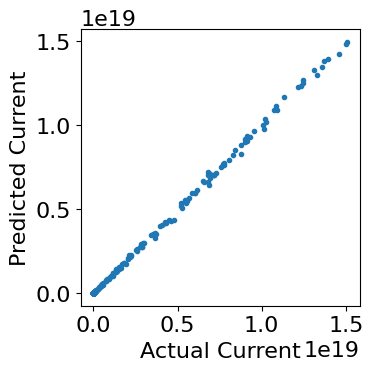

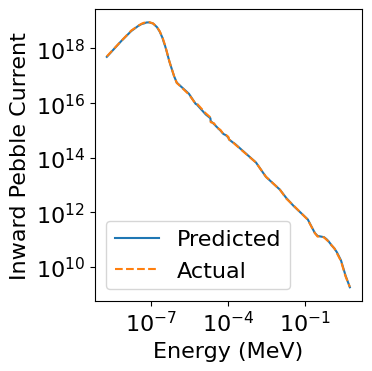

In [8]:
log_current_features = log_scale_data(current_features, current_log_columns)
all_current_data_stdlog, _,_ = standardize(log_current_features, 
                        mean=current_std_data["feature_mean"],
                        std=current_std_data["feature_std"])
all_current_predictions_stdlog = current_rfr_model.predict(all_current_data_stdlog)
all_current_predictions = 10**unstandardize(all_current_predictions_stdlog,
                                        current_std_data["target_mean"],
                                        current_std_data["target_std"])

max_value = max([np.max(all_current_predictions),np.max(current_targets)])

energy_grid = current_features["energy"].unique()
fig, ax = plt.subplots(ncols=1, figsize=(4,4))
ax.set_xlabel("Actual Current  ")
ax.set_ylabel("Predicted Current")


ax.plot(current_targets[0:400], all_current_predictions[0:400],".")
fig.tight_layout()
plt.savefig("figures/current_predicted_vs_actual.png")
plt.show()

fig, ax = plt.subplots(ncols=1, figsize=(4,4))
ax.set_xlabel("Energy (MeV)")
ax.set_ylabel("Inward Pebble Current")
ax.set_xscale("log")
ax.set_yscale("log")
fig.tight_layout()

step=1
r = current_features["radius"].unique()[step]
h = current_features["height"].unique()[step]
indexes = current_features[(current_features["radius"]==r) & (current_features["height"]==h)].index
energy = current_features["energy"].iloc[indexes]
prediction = all_current_predictions[indexes]
actual = current_targets.iloc[indexes]
ax.plot(energy, prediction,label="Predicted")
ax.plot(energy, actual,label="Actual",linestyle="dashed")
ax.legend()
fig.tight_layout()
plt.savefig("figures/current_profile_predicted_vs_actual.png")
plt.show()

# Flux Model

In [9]:
best_params = {'max_depth': 30, 
               'n_estimators': 300, 
               'n_jobs': -1,} # Set to your number of cores
flux_rfr_model = RandomForestRegressor(random_state=0)
flux_rfr_model.set_params(**best_params)
flux_rfr_model.fit(flux_std_data["training_features"], flux_std_data["training_target"])
flux_rfr_score = flux_rfr_model.score(flux_std_data["testing_features"], flux_std_data["testing_target"])
print(f"Flux RFR score: {flux_rfr_score}")

/global/home/users/ikolaja/.local/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Flux RFR score: 0.9989350372502296


In [10]:
ZAI_list = [922350, 922380, 942390, 942410, 541350, 551370, 10010, 10030, 20040, 30070, 40100, 50100, 50110, 60120, 60140, 80160, 80170, 290670, 300660, 300670, 300680, 300700, 300720, 310690, 310710, 310720, 320720, 320730, 320740, 320760, 320770, 320780, 330750, 330760, 330770, 330780, 330790, 330810, 340760, 340770, 340780, 340790, 340791, 340800, 340810, 340811, 340820, 340830, 340840, 340850, 340860, 350790, 350810, 350820, 350830, 350840, 350841, 350850, 350860, 350870, 350880, 360800, 360810, 360820, 360830, 360831, 360840, 360850, 360851, 360860, 360870, 360880, 360890, 360900, 360910, 370830, 370840, 370850, 370860, 370870, 370880, 370890, 370900, 370901, 370910, 370920, 370930, 380860, 380870, 380880, 380890, 380900, 380910, 380920, 380930, 380940, 380950, 390880, 390890, 390891, 390900, 390910, 390911, 390920, 390930, 390940, 390950, 390960, 390961, 390970, 400900, 400910, 400920, 400930, 400940, 400950, 400960, 400970, 400980, 400990, 401000, 401010, 401020, 410930, 410931, 410940, 410950, 410951, 410960, 410970, 410980, 410981, 410990, 410991, 411000, 411010, 420940, 420950, 420960, 420970, 420980, 420990, 421000, 421010, 421020, 421030, 421040, 421050, 421060, 430980, 430990, 430991, 431000, 431010, 431020, 431030, 431040, 431050, 431060, 431070, 440990, 441000, 441010, 441020, 441030, 441040, 441050, 441060, 441070, 441080, 441090, 451020, 451021, 451030, 451031, 451040, 451041, 451050, 451051, 451060, 451061, 451070, 451080, 451090, 461040, 461050, 461060, 461070, 461080, 461090, 461100, 461110, 461120, 471090, 471091, 471101, 471110, 471111, 471120, 471130, 471150, 481100, 481110, 481120, 481130, 481131, 481140, 481150, 481151, 481160, 481170, 481171, 481180, 491130, 491150, 491151, 491170, 491171, 491191, 501150, 501160, 501170, 501171, 501180, 501190, 501191, 501200, 501210, 501211, 501220, 501230, 501231, 501240, 501250, 501251, 501260, 501270, 501271, 501280, 501290, 501291, 501300, 501301, 501310, 501311, 501320, 511210, 511220, 511230, 511240, 511250, 511260, 511261, 511270, 511280, 511281, 511290, 511300, 511301, 511310, 511320, 511321, 511330, 521220, 521230, 521231, 521240, 521250, 521251, 521260, 521270, 521271, 521280, 521290, 521291, 521300, 521310, 521311, 521320, 521330, 521331, 521340, 521350, 521360, 531260, 531270, 531280, 531290, 531300, 531301, 531310, 531320, 531321, 531330, 531340, 531341, 531350, 531360, 531361, 531370, 531380, 541280, 541290, 541300, 541310, 541311, 541320, 541330, 541331, 541340, 541351, 541360, 541370, 541380, 541390, 541400, 551320, 551330, 551340, 551341, 551350, 551351, 551360, 551380, 551381, 551390, 551400, 551410, 561320, 561340, 561350, 561360, 561370, 561371, 561380, 561390, 561400, 561410, 561420, 561430, 561440, 561450, 571370, 571380, 571390, 571400, 571410, 571420, 571430, 571440, 571450, 571460, 571461, 581380, 581390, 581400, 581410, 581420, 581430, 581440, 581450, 581460, 581470, 581480, 591410, 591420, 591421, 591430, 591440, 591441, 591450, 591460, 591470, 591480, 591481, 591490, 591510, 601420, 601430, 601440, 601450, 601460, 601470, 601480, 601490, 601500, 601510, 601520, 601530, 611460, 611470, 611480, 611481, 611490, 611510, 611520, 611530, 611540, 621470, 621480, 621490, 621500, 621510, 621520, 621530, 621540, 621550, 621560, 621570, 621580, 631510, 631520, 631530, 631540, 631541, 631550, 631560, 631570, 631580, 631590, 641520, 641540, 641550, 641560, 641570, 641580, 641590, 641600, 651580, 651590, 651600, 651610, 661600, 661610, 661620, 661630, 661640, 661660, 671650, 671660, 671661, 681660, 681670, 681680, 681690, 681700, 691690, 691710, 701720, 902310, 902320, 902340, 912310, 912340, 922320, 922340, 922360, 922370, 922390, 932370, 932380, 932390, 942380, 942400, 942420, 952410]

def rename_ZAI_columns(dataframe):
    '''
    Convert the isotope headers of a dataframe from ZAId integer format into symbol-mass string format.
    '''
    z_map = {'Ac': 89, 'Ag': 47, 'Al': 13, 'Am': 95, 'Ar': 18, 'As': 33, 'At': 85, 'Au': 79, 'B': 5, 'Ba': 56, 'Be': 4,
             'Bh': 107, 'Bi': 83, 'Bk': 97, 'Br': 35, 'C': 6, 'Ca': 20, 'Cd': 48, 'Ce': 58,
             'Cf': 98, 'Cl': 17, 'Cm': 96, 'Co': 27, 'Cr': 24, 'Cs': 55, 'Cu': 29, 'Ds': 110, 'Db': 105, 'Dy': 66, 'Er': 68,
             'Es': 99, 'Eu': 63, 'F': 9, 'Fe': 26, 'Fm': 100, 'Fr': 87, 'Ga': 31, 'Gd':
                 64, 'Ge': 32, 'H': 1, 'He': 2, 'Hf': 72, 'Hg': 80, 'Ho': 67, 'Hs': 108, 'I': 53, 'In': 49, 'Ir': 77,
             'K': 19, 'Kr': 36, 'La': 57, 'Li': 3, 'Lr': 103, 'Lu': 71, 'Md': 101, 'Mg': 12, 'Mn':
                 25, 'Mo': 42, 'Mt': 109, 'N': 7, 'Na': 11, 'Nb': 41, 'Nd': 60, 'Ne': 10, 'Ni': 28, 'No': 102, 'Np': 93,
             'O': 8, 'Os': 76, 'P': 15, 'Pa': 91, 'Pb': 82, 'Pd': 46, 'Pm': 61, 'Po': 84, 'Pr':
                 59, 'Pt': 78, 'Pu': 94, 'Ra': 88, 'Rb': 37, 'Re': 75, 'Rf': 104, 'Rg': 111, 'Rh': 45, 'Rn': 86, 'Ru': 44,
             'S': 16, 'Sb': 51, 'Sc': 21, 'Se': 34, 'Sg': 106, 'Si': 14, 'Sm': 62, 'Sn': 50,
             'Sr': 38, 'Ta': 73, 'Tb': 65, 'Tc': 43, 'Te': 52, 'Th': 90, 'Ti': 22, 'Tl': 81, 'Tm': 69, 'U': 92, 'V': 23,
             'W': 74, 'Xe': 54, 'Y': 39, 'Yb': 70, 'Zn': 30, 'Zr': 40}
    z_map_inv = {v: k for k, v in z_map.items()}
    rename_map = {}

    for column in dataframe.columns:
        raw_label = column
        column = str(column)
        if not column.isnumeric():
            continue
        iso_num = int(column[-1])
        a = int(column[-4:-1])
        z = int(column[:-4])
        renamed = f"{z_map_inv[z]}-{a}"
        if iso_num > 0:
            renamed += "m"
        rename_map[raw_label] = renamed
    renamed_dataframe = dataframe.rename(columns=rename_map)

    return renamed_dataframe

In [11]:
dummy_nuclide_df = flux_std_data["training_features"]
nuclide_rename_dict = {"current":"Current"}
for nuclide in dummy_nuclide_df.columns:
    nuclide_rename_dict[nuclide] = nuclide.replace("<lib>","0")
dummy_nuclide_df = dummy_nuclide_df.rename(columns=nuclide_rename_dict)
dummy_nuclide_df = rename_ZAI_columns(dummy_nuclide_df)
dummy_nuclide_df

,H-1,H-2,H-3,He-3,He-4,Li-6,Li-7,Se-74,Se-80,Se-82,...,Pu-234,Am-238,Cm-238,Pd-100,Ce-134,Xe-122,Ba-128,La-134,Tc-94,I-122
34059,0.354281,0.372272,0.328185,0.359620,0.346197,0.335433,0.338827,0.343846,0.345790,0.345845,...,-0.224313,-0.107838,-0.10783,-0.128655,-0.116916,-0.052098,-0.072733,-0.066127,-0.048203,-0.041964
14452,0.397469,0.416756,0.424070,0.421678,0.386359,0.397350,0.429319,0.400266,0.382356,0.382323,...,-0.224313,-0.107838,-0.10783,-0.128655,-0.116916,-0.052098,-0.072733,-0.066127,-0.048203,-0.041964
19779,0.401327,0.369232,0.398515,0.382060,0.379972,0.393447,0.389061,0.396028,0.380957,0.380920,...,-0.224313,-0.107838,-0.10783,-0.128655,-0.116916,-0.052098,-0.072733,-0.066127,-0.048203,-0.041964
3578,-2.727363,-2.725514,-2.725370,-2.725361,-2.728584,-2.717399,-2.715023,-2.727459,-2.728684,-2.728686,...,-0.224313,-0.107838,-0.10783,-0.128655,-0.116916,-0.052098,-0.072733,-0.066127,-0.048203,-0.041964
21396,0.393618,0.397643,0.405540,0.385991,0.382810,0.394013,0.414576,0.401155,0.382210,0.382186,...,-0.224313,-0.107838,-0.10783,-0.128655,-0.116916,-0.052098,-0.072733,-0.066127,-0.048203,-0.041964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23817,0.395764,0.413663,0.420759,0.407766,0.384837,0.395215,0.432096,0.403430,0.382903,0.382894,...,-0.224313,-0.107838,-0.10783,-0.128655,-0.116916,-0.052098,-0.072733,-0.066127,-0.048203,-0.041964
29384,0.392662,0.414888,0.430182,0.433386,0.384912,0.408164,0.421522,0.401984,0.376478,0.376437,...,-0.224313,-0.107838,-0.10783,-0.128655,-0.116916,-0.052098,-0.072733,-0.066127,-0.048203,-0.041964
33874,0.352258,0.366342,0.376653,0.410426,0.345826,0.334247,0.327880,0.341507,0.344599,0.344660,...,-0.224313,-0.107838,-0.10783,-0.128655,-0.116916,-0.052098,-0.072733,-0.066127,-0.048203,-0.041964
9344,0.384463,0.348996,0.305821,0.317639,0.345710,0.339020,0.280529,0.313799,0.353021,0.353060,...,-0.224313,-0.107838,-0.10783,-0.128655,-0.116916,-0.052098,-0.072733,-0.066127,-0.048203,-0.041964


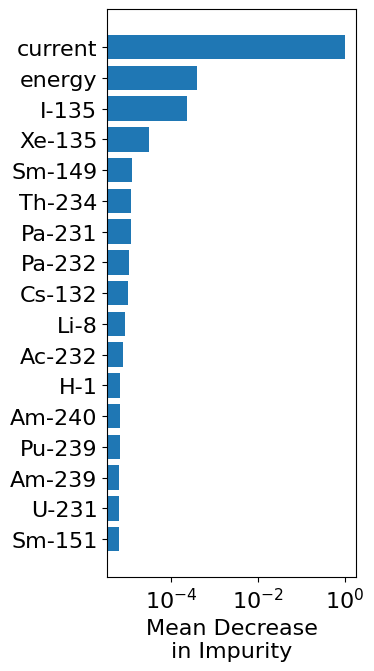

In [12]:
plt.rcParams.update({'font.size': 16})


num_features_to_use = 30+2
num_features_to_plot = 15+2

fig, ax = plt.subplots(ncols=1, figsize=(4,7))

sorted_indices = np.argsort(flux_rfr_model.feature_importances_)[-num_features_to_plot:]
flux_labels = dummy_nuclide_df.columns[sorted_indices]
flux_importances =flux_rfr_model.feature_importances_[sorted_indices]
y_pos = np.arange(len(flux_labels))

features_to_use = flux_std_data["training_features"].columns[sorted_indices]

ax.barh(y_pos, flux_importances, align='center')
ax.set_yticks(y_pos, labels=list(flux_labels))
# o].invert_yaxis()  # labels read top-to-bottom
#ax.set_xlim(-0.1,1.1*max(current_importances))
ax.set_xlabel("Mean Decrease\nin Impurity")
ax.set_xscale("log")
fig.tight_layout()
plt.savefig("figures/hyperfidelity/flux_feature_importance.png")
plt.show()


feature_labels = flux_std_data["testing_features"].columns
importances = flux_rfr_model.feature_importances_

features_to_use = feature_labels[np.argsort(importances)[-features_to_use:]]

plot_indices = np.argsort(importances)[-features_to_plot:]
top_importance_vals = importances[plot_indices]
top_plot_features = feature_labels[plot_indices]

plt.title(f"Feature Importance for Flux")
plt.xlabel("Feature")
plt.ylabel("Mean decrease in impurity")

plt.bar(top_plot_features, top_importance_vals, color ='maroon', 
        width = 0.4)
plt.xticks(rotation=30)


plt.tight_layout()
plt.savefig(f"training_data/flux_top_features.png")
plt.show()

plt.title(f"Nuclide Importance for Flux")
plt.xlabel("Feature")
plt.ylabel("Mean decrease in impurity")

plt.bar(top_plot_features[:-2], top_importance_vals[:-2], color ='maroon', 
        width = 0.4)
plt.xticks(rotation=30)


plt.tight_layout()
plt.savefig(f"training_data/flux_top_nuclides.png")
plt.show()

plt.rcParams.update({'font.size': 16})

feature_rename_key = {"energy": "Energy",
                      "core_flux_at_energy": "Core Flux at Energy",
                      "interpolated_flux": "Interpolated Flux",
                      "interpolated_power": "Interpolated Power",
                      "height": "Pebble Height",
                      "radius": "Pebble Radial Position",
                      "local_fima": "Avg %FIMA Nearby Pebbles",
                      "local_graphite_frac": "% Nearby Graphite Pebbles"}


current_labels = current_std_data["testing_features"].columns
current_importances = current_rfr_model.feature_importances_

fig, ax = plt.subplots(ncols=1, figsize=(3,6), sharey=True,gridspec_kw = {'wspace':0, 'hspace':0})

sorted_indices = np.argsort(current_rfr_model.feature_importances_)
current_labels = current_std_data["testing_features"].rename(columns=feature_rename_key).columns[sorted_indices]
current_importances = current_rfr_model.feature_importances_[sorted_indices]
y_pos = np.arange(len(current_labels))

ax.barh(y_pos, current_importances, align='center')
ax.set_yticks(y_pos, labels=list(current_labels))
# o].invert_yaxis()  # labels read top-to-bottom
#ax.set_xlim(-0.1,1.1*max(current_importances))
ax.set_xlabel("Mean Decrease\nin Impurity")
plt.tight_layout()
plt.savefig("figures/hyperfidelity/current_feature_importance.png")
plt.show()

In [13]:
best_params = {'max_depth': 30, 
               'n_estimators': 1000, 
               'n_jobs': 40,} # Set to your number of cores
flux_imp_rfr_model = RandomForestRegressor(random_state=0)
flux_imp_rfr_model.set_params(**best_params)
flux_imp_rfr_model.fit(flux_std_data["training_features"][features_to_use], flux_std_data["training_target"])
flux_imp_rfr_score = flux_imp_rfr_model.score(flux_std_data["testing_features"][features_to_use], flux_std_data["testing_target"])
print(f"Flux RFR (top 30 nuclides) score: {flux_imp_rfr_score}")

/global/home/users/ikolaja/.local/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Flux RFR (top 30 nuclides) score: 0.998970270150156


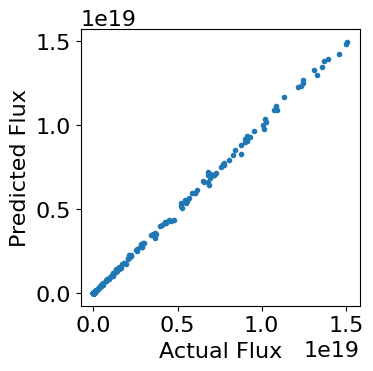

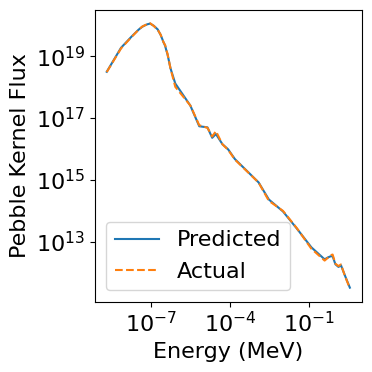

In [14]:
log_flux_features = log_scale_data(flux_features, "all")
all_flux_data_stdlog, _,_ = standardize(log_flux_features, 
                        mean=flux_std_data["feature_mean"],
                        std=flux_std_data["feature_std"])
all_flux_predictions_stdlog = flux_imp_rfr_model.predict(all_flux_data_stdlog[features_to_use])
all_flux_predictions = 10**unstandardize(all_flux_predictions_stdlog,
                                        flux_std_data["target_mean"],
                                        flux_std_data["target_std"])



energy_grid = current_features["energy"].unique()

fig, ax = plt.subplots(ncols=1, figsize=(4,4))
ax.set_xlabel("Actual Flux")
ax.set_ylabel("Predicted Flux")
ax.plot(current_targets[0:400], all_current_predictions[0:400],".")
fig.tight_layout()
plt.savefig("figures/flux_predicted_vs_actual.png")
plt.show()



fig, ax = plt.subplots(ncols=1, figsize=(4,4))
ax.set_xlabel("Energy (MeV)")
ax.set_ylabel("Pebble Kernel Flux")
ax.set_xscale("log")
ax.set_yscale("log")
fig.tight_layout()

step=0
s = 0
indexes = []
last_energy = -1
i = 0
while s < step+1:
    if last_energy < flux_features["energy"].iloc[i]:
        indexes += [i]
        last_energy = flux_features["energy"].iloc[i]
    else:
        s += 1
    i += 1
#concentrations = flux_features.drop(columns=["energy","current"]).unique()[step]
#indexes = flux_features[flux_features.drop(columns=["energy","current"]) == concentrations].index


energy = flux_features["energy"].iloc[indexes]
prediction = all_flux_predictions[indexes]
actual = flux_targets.iloc[indexes]

ax.plot(energy, prediction,label="Predicted")
ax.plot(energy, actual,label="Actual",linestyle="dashed")
ax.legend()
fig.tight_layout()
plt.savefig("figures/flux_profile_predicted_vs_actual.png")
plt.show()


plt.figure()
plt.xlabel("Actual Pebble Flux Values")
plt.ylabel("Predicted Pebble Flux Values")
plt.plot(current_targets[0:400], all_current_predictions[0:400],".")
plt.show()

plt.figure()
plt.xlabel("Energy (MeV)")
plt.ylabel("Pebble Kernel Flux")
plt.xscale("log")
plt.yscale("log")

step=0
s = 0
indexes = []
last_energy = -1
i = 0
while s < step+1:
    if last_energy < flux_features["energy"].iloc[i]:
        indexes += [i]
        last_energy = flux_features["energy"].iloc[i]
    else:
        s += 1
    i += 1
#concentrations = flux_features.drop(columns=["energy","current"]).unique()[step]
#indexes = flux_features[flux_features.drop(columns=["energy","current"]) == concentrations].index


energy = flux_features["energy"].iloc[indexes]
prediction = all_flux_predictions[indexes]
actual = flux_targets.iloc[indexes]
plt.plot(energy, prediction,label="Predicted")
plt.plot(energy, actual,label="Actual")
plt.legend()
plt.show()

Next we save the models and standardization parameters so the model can be used in the simulation.

In [15]:
with open("flux_features.txt", "w") as f:
    for feature in features_to_use:
        f.write(f"{feature},")

In [16]:
model_data = pickle.dumps(flux_imp_rfr_model)
with open("ml_models/flux_rfr.pkl", 'wb') as f:
    f.write(model_data)
model_data = pickle.dumps(current_rfr_model)
with open("ml_models/current_rfr.pkl", 'wb') as f:
    f.write(model_data)
flux_std_data["feature_mean"].to_csv("ml_models/flux_rfr_feature_mean.csv", header=True)
flux_std_data["feature_std"].to_csv("ml_models/flux_rfr_feature_std.csv", header=True)
flux_std_data["target_mean"].to_csv("ml_models/flux_rfr_target_mean.csv", header=True)
flux_std_data["target_std"].to_csv("ml_models/flux_rfr_target_std.csv", header=True)
current_std_data["feature_mean"].to_csv("ml_models/current_rfr_feature_mean.csv", header=True)
current_std_data["feature_std"].to_csv("ml_models/current_rfr_feature_std.csv", header=True)
current_std_data["target_mean"].to_csv("ml_models/current_rfr_target_mean.csv", header=True)
current_std_data["target_std"].to_csv("ml_models/current_rfr_target_std.csv", header=True)

New: Save current and flux models as objects

In [17]:
current_model = SingleModelWrapper(current_rfr_model, 
                                   current_labels_internal, 
                                   current_std_data["feature_mean"], 
                                   current_std_data["feature_std"], 
                                   current_std_data["target_mean"], 
                                   current_std_data["target_std"], 
                                   target_label="current", 
                                   log_features = current_log_columns)

flux_model = SingleModelWrapper(flux_imp_rfr_model, 
                                   features_to_use, 
                                   flux_std_data["feature_mean"], 
                                   flux_std_data["feature_std"], 
                                   flux_std_data["target_mean"], 
                                   flux_std_data["target_std"], 
                                   target_label="flux", 
                                   log_features = "all")

In [18]:
current_predictions = current_model.predict(current_features)
flux_predictions = flux_model.predict(flux_features)

In [19]:
# Ensure that conversion to single object didn't screw up any normalization steps
assert np.allclose(current_predictions.to_numpy(), all_current_predictions)
assert np.allclose(flux_predictions.to_numpy(), all_flux_predictions)

In [20]:
with open("ml_models/flux_model.pkl", 'wb') as f:
    model_data = pickle.dumps(flux_model)
    f.write(model_data)

with open("ml_models/current_model.pkl", 'wb') as f:
    model_data = pickle.dumps(current_model)
    f.write(model_data)

# Cross Section Models

In [7]:
with open("reaction_keys.txt", 'r') as f:
    reaction_keys = f.readline().replace("\n","").split(",")[:-1]
with open("flux_features.txt", 'r') as f:
    features_to_use = f.readline().replace("\n","").split(",")[:-1]

In [8]:
model_dict = {}
target_mean_dict = {}
target_stdev_dict = {}

In [9]:
energy_group_labels = pd.read_csv(f"ml_models/xs_models/922350-18_feature_mean.csv", index_col = 0).T.columns.astype(str)

In [10]:
energy_group_labels

Index(['2e-09', '7e-09', '1.765e-08', '3.265e-08', '4.5e-08', '5.5e-08',
       '7e-08', '9e-08', '1.25e-07', '1.75e-07', '2.25e-07', '2.875e-07',
       '3.375e-07', '3.625e-07', '4.125e-07', '5.375e-07', '8.175e-07',
       '1.045e-06', '1.105e-06', '3.065e-06', '5.625e-06', '6.375e-06',
       '6.6875e-06', '6.9375e-06', '1.375e-05', '2.085e-05', '2.1475e-05',
       '2.8875e-05', '3.6565e-05', '5.1065e-05', '6.625e-05', '8.435e-05',
       '0.0001031', '0.0001105', '0.00011675', '0.0001526', '0.0001896',
       '0.0012207', '0.002995', '0.01037', '0.0185', '0.035', '0.125', '0.235',
       '0.3', '0.4', '0.535', '0.675', '0.80555', '1.0305', '1.35', '1.675',
       '2.425', '3.652', '5.369', '13.217'],
      dtype='object')

In [18]:
xs_scores = {}
total_flux_features = pd.read_csv(f"training_data/xs_data_total_flux.csv.gz", index_col=0)
total_flux_target =  pd.read_csv(f"training_data/xs_targets_total_flux.csv.gz", index_col=0)
total_flux_features.columns = energy_group_labels
xs_std_data = create_training_split(total_flux_features, 
                                         total_flux_target, 
                                         train_split, 
                                         log_scale_features="all",
                                         seed=42)
xs_feature_mean = xs_std_data["feature_mean"]
xs_feature_stdev = xs_std_data["feature_std"]
xs_feature_mean.to_csv(f"ml_models/xs_models/xs_feature_mean.csv", header=True)
xs_feature_stdev.to_csv(f"ml_models/xs_models/xs_feature_std.csv", header=True)

for key in reaction_keys:
    model_path = f"ml_models/xs_models/{key}.pkl"
    #if os.path.exists(model_path):
    #    print(f"{key} already exists")
    #    continue
    xs_features = pd.read_csv(f"training_data/xs_data_{key}.csv.gz", index_col=0)
    xs_features.columns = energy_group_labels
    xs_target =  pd.read_csv(f"training_data/xs_targets_{key}.csv.gz", index_col=0)
    xs_std_data = create_training_split(xs_features, 
                                             xs_target, 
                                             train_split, 
                                             log_scale_features="all",
                                             data_mean = xs_feature_mean,
                                             data_std = xs_feature_stdev,
                                             seed=42)
    best_params = {'max_depth': 18, 
                   'n_estimators': 100, 
                   'n_jobs': -1,} # Set to your number of cores
    xs_rfr_model = RandomForestRegressor(random_state=0)
    xs_rfr_model.set_params(**best_params)
    if key != "total_flux":
        xs_rfr_model.fit(xs_std_data["training_features"], xs_std_data["training_target"]["xs"])
        xs_rfr_score = xs_rfr_model.score(xs_std_data["testing_features"], xs_std_data["testing_target"]["xs"])
    else:
        xs_rfr_model.fit(xs_std_data["training_features"], xs_std_data["training_target"]["total_flux"])
        xs_rfr_score = xs_rfr_model.score(xs_std_data["testing_features"], xs_std_data["testing_target"]["total_flux"])
    print(f"{key} cross section RFR score: {xs_rfr_score} - {len(xs_target)} samples")
    xs_scores[key] = xs_rfr_score
    model_dict[key] = xs_rfr_model
    target_mean_dict[key] = xs_std_data["target_mean"]
    target_stdev_dict[key] = xs_std_data["target_std"]
    model_data = pickle.dumps(xs_rfr_model)
    with open(model_path, 'wb') as f:
        f.write(model_data)
    target_mean_dict[key].to_csv(f"ml_models/xs_models/{key}_target_mean.csv", header=True)
    target_stdev_dict[key].to_csv(f"ml_models/xs_models/{key}_target_std.csv", header=True)

541330-16 cross section RFR score: 0.8344533537110891 - 3700 samples
541340-17 cross section RFR score: -0.07433330948524053 - 756 samples
922400-102 cross section RFR score: 0.8409052807720938 - 4636 samples
400950-107 cross section RFR score: 0.7539942433883905 - 3817 samples
541300-102 cross section RFR score: 0.9825850566024353 - 5741 samples
912320-17 cross section RFR score: -0.11362103689462377 - 1252 samples
441030-102 cross section RFR score: 0.9225651741200973 - 5390 samples
621510-17 cross section RFR score: -0.07719250214162043 - 1563 samples
350810-102 cross section RFR score: 0.8628553916473919 - 4906 samples
922350-16 cross section RFR score: 0.9416534399679678 - 4049 samples
932350-17 cross section RFR score: -0.10686184010491173 - 1304 samples
952430-102 cross section RFR score: 0.7080275349836198 - 5414 samples
370870-16 cross section RFR score: 0.11238611792047404 - 2432 samples
400910-16 cross section RFR score: 0.5996232490545274 - 3302 samples
591410-16 cross sect

In [16]:
# Collect individual models and combine them into one object
model_dict = {}
xs_target_mean_dict = {}
xs_target_stdev_dict = {}

for key in reaction_keys:
    model_path = f"ml_models/xs_models/{key}.pkl"
    print(f"Reading  {key} data")
    metadata = {}  
    with open(model_path, 'rb') as f:
        model_dict[key] = pickle.load(f)
    xs_target_mean_dict[key] = pd.read_csv(f"ml_models/xs_models/{key}_target_mean.csv", index_col = 0).T.iloc[0]
    xs_target_stdev_dict[key] = pd.read_csv(f"ml_models/xs_models/{key}_target_std.csv", index_col = 0).T.iloc[0]

Reading  541330-16 data
Reading  541340-17 data
Reading  922400-102 data
Reading  400950-107 data
Reading  541300-102 data
Reading  912320-17 data
Reading  441030-102 data
Reading  621510-17 data
Reading  350810-102 data
Reading  922350-16 data
Reading  932350-17 data
Reading  952430-102 data
Reading  370870-16 data
Reading  400910-16 data
Reading  591410-16 data
Reading  531310-107 data
Reading  601470-17 data
Reading  531300-103 data
Reading  932360-16 data
Reading  461070-17 data
Reading  360830-107 data
Reading  360860-102 data
Reading  601460-16 data
Reading  481110-103 data
Reading  561370-102 data
Reading  932380-18 data
Reading  420950-102 data
Reading  461060-102 data
Reading  952421-18 data
Reading  561400-103 data
Reading  902330-16 data
Reading  481060-107 data
Reading  922360-37 data
Reading  461100-103 data
Reading  441010-107 data
Reading  410940-103 data
Reading  942360-17 data
Reading  380900-103 data
Reading  932370-37 data
Reading  581360-17 data
Reading  922330-102 


KeyboardInterrupt



In [46]:
xs_models = XSModelWrapper(model_dict, 
                          energy_group_labels, 
                          reaction_keys, 
                          xs_feature_mean, 
                          xs_feature_stdev, 
                          xs_target_mean_dict, 
                          xs_target_stdev_dict)

In [47]:
total_flux_features = pd.read_csv(f"training_data/xs_data_total_flux.csv.gz", index_col=0)
total_flux_features.columns = energy_group_labels

all_xs_predictions = xs_models.predict(total_flux_features)

In [48]:
all_flux_features, _,_ =standardize(np.log10(total_flux_features+1e-100), mean=xs_feature_mean, std=xs_feature_stdev)
flux_predictions = model_dict["total_flux"].predict(all_flux_features)
flux_predictions=10**unstandardize(flux_predictions, mean=xs_target_mean_dict["total_flux"], std=xs_target_stdev_dict["total_flux"])

In [49]:
# Assert standarization is happening correctly
assert np.allclose(all_xs_predictions["total_flux"], flux_predictions)

In [50]:
with open("ml_models/xs_models.pkl", 'wb') as f:
    model_data = pickle.dumps(xs_models)
    f.write(model_data)

# Apply Models

In [6]:
with open("ml_models/current_model.pkl", 'rb') as f:
    current_model = pickle.load(f)
with open("ml_models/flux_model.pkl", 'rb') as f:
    flux_model = pickle.load(f)
with open("ml_models/xs_models.pkl", 'rb') as f:
    xs_models = pickle.load(f)

In [9]:
directory = "gFHR_sequence"
step = 490
num_samples = 100
feature_search_radius = 20
initial_actinides = 0.00466953 + 0.0189728

In [10]:
raw_positions = pd.read_csv(f"{directory}/pebble_positions_{step}.csv", sep=" ", header=None,
                       names=["x","y","z","size","universe"])
positions = raw_positions.sample(num_samples).reset_index(drop=True)

In [11]:
def extract_mesh_data(pebble_positions, raw_positions, step, substep, directory = "gFHR_sequence", 
                      pebble_kernel_volume=PEBBLE_KERNEL_VOLUME, pebble_surface_area=PEBBLE_SURFACE_AREA):

    pebble_positions["radius"] = round(np.sqrt(pebble_positions['x']**2+pebble_positions['y']**2),4)
    pebble_positions['height'] = round(pebble_positions['z'],4)
    pebble_positions["local_fima"] = 0.0
    pebble_positions["local_graphite_frac"] = 0.0
    conc_series_list = []
    conc_series_final_list = []
    bumat_file = f"gFHR_equilibrium_{step}.serpent.bumat{substep}"
    bumat_data = extract_from_bumat(f"{directory}/{bumat_file}", return_list=False)
    for index, row in pebble_positions.iterrows():
        conc_series_list += [pd.Series(bumat_data[row["universe"][1:]])]
        xsq = (row["x"] - raw_positions['x']) ** 2
        ysq = (row["y"] - raw_positions['y']) ** 2
        zsq = (row["z"] - raw_positions['z']) ** 2
        dist = np.sqrt(xsq + ysq + zsq)
        local_indices = list(dist[dist < feature_search_radius].index)
        
        fima_values = []
        is_graphite = []
        for ind in local_indices:
            data = raw_positions.iloc[ind]
            material_id = data['universe'][1:]
            if "fuel" in material_id:
                material_conc = bumat_data[material_id]
                fima_values += [get_fima(material_conc, initial_actinides)]
                is_graphite += [0]
            else:
                is_graphite += [1]
        pebble_positions.loc[index, "local_graphite_frac"] = np.mean(is_graphite)
        pebble_positions.loc[index, "local_fima"] = np.mean(fima_values)
    conc_final_df = pd.DataFrame(conc_series_final_list).fillna(0.0)
    conc_final_df["universe"] = pebble_positions["universe"]
    pebble_positions = pebble_positions.drop(columns=["x","y","z","size","universe"])
    
    conc_df = pd.DataFrame(conc_series_list).fillna(0.0)
    
    
    current_energy_widths = np.diff(ENERGY_GRID_56)
    det_name = f"gFHR_equilibrium_{step}.serpent_det{substep}.m"
    current_aux_features = ["local_fima", "local_graphite_frac"]
    meshes = read_det_file(f"{directory}/{det_name}", 
                            read_pebbles=False,
                            meshes_to_read=["coarse_7group_flux",
                                            "core_56group_flux",
                                            "subzone_power"], 
                            mesh_grids_rze = [(RADIUS_GRID_3, HEIGHT_GRID_8, ENERGY_GRID_7),
                                              ([0.0, 120.0], [60.0, 369.47], ENERGY_GRID_56),
                                              (RADIUS_GRID_8, HEIGHT_GRID_20, [0,20]) ] )
    

    current_features = expand_pebble_features_by_energy(pebble_positions)

    core_flux_at_energy = []
    for i in range(len(current_features)):
        idx = (np.abs(ENERGY_GRID_56 - float(current_features["energy"].iloc[i]))).argmin()
        core_flux_at_energy += [meshes["core_56group_flux"]["data"][0,0,idx-1]]
    
    current_features["core_flux_at_energy"] = core_flux_at_energy

    interpolated_power = interpolate_core_power(current_features[["radius","height"]], 
                          meshes["subzone_power"]["data"], 
                          512,
                          do_plot=True)

    current_features["interpolated_power"] = interpolated_power
    
    interpolated_flux = interpolate_core_flux_3d(current_features[["radius","height","energy"]], 
                          meshes["coarse_7group_flux"]["data"], 
                          1024,
                          plot_energy=1.7650e-08)

    current_features["interpolated_flux"] = interpolated_flux


    return current_features, conc_df, bumat_data


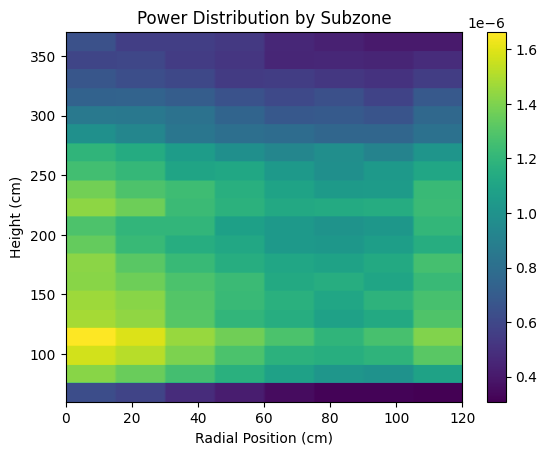

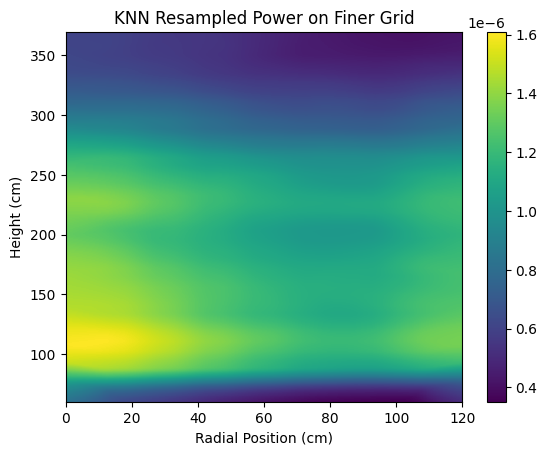

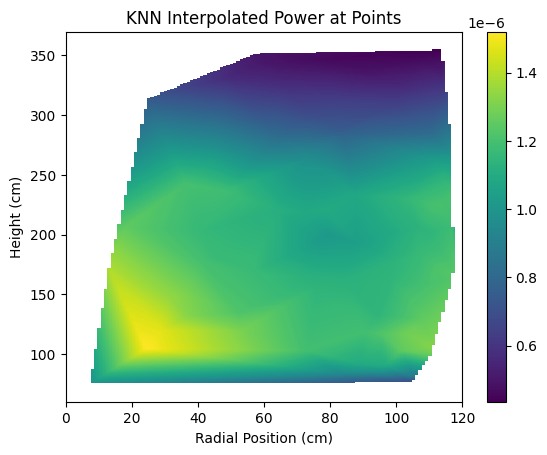

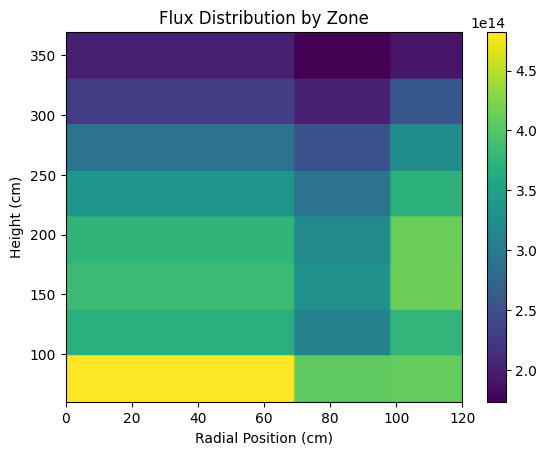

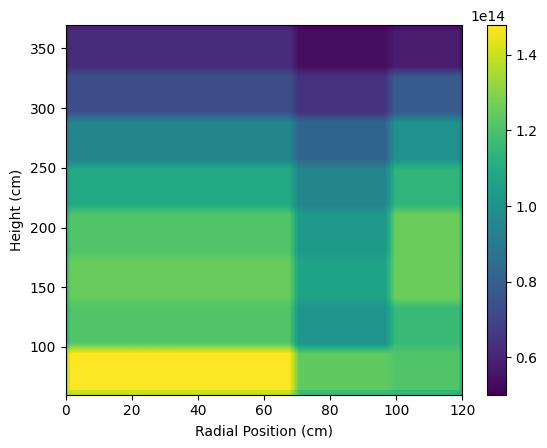

/global/scratch/users/ikolaja/PEARLSim_dev/PEARLSim/pearlsim/ml_utilities.py:442: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_plot_df["energy"] = group_energy


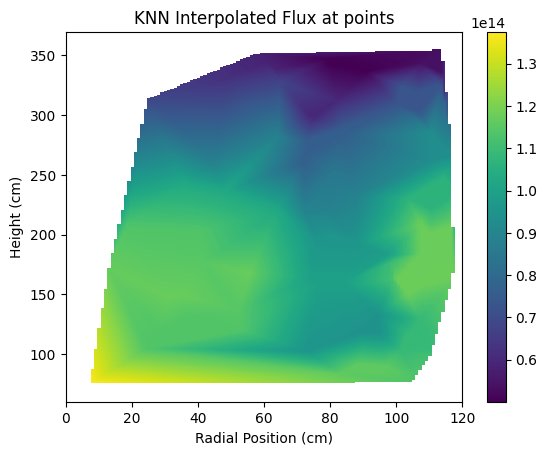

In [94]:
position_df, conc_df,  bumat_dict = extract_mesh_data(positions, raw_positions, 490, 0)

In [95]:
predicted_flux_series_list = []

flux_nuclide_labels = list(flux_model.input_column_labels)
flux_nuclide_labels.remove("energy")
flux_nuclide_labels.remove("current")

for i in range(num_samples):
    start_ind = i*56
    end_ind = (i+1)*56
    current_chunk = position_df.iloc[start_ind:end_ind].reset_index(drop=True)
    current = current_model.predict(current_chunk)

    conc_series = conc_df[flux_nuclide_labels].iloc[i]
    flux_feature_list = []
    for e in range(len(current)):
        row = conc_series.copy()
        row["energy"] = current_chunk["energy"].iloc[e]
        row["current"] = current[e]
        flux_feature_list += [row]
    flux_features = pd.DataFrame(flux_feature_list).reset_index(drop=True)
    flux = flux_model.predict(flux_features)*np.diff(ENERGY_GRID_56)*PEBBLE_KERNEL_VOLUME
    predicted_flux_series_list += [flux]

In [97]:
flux_df = pd.DataFrame(predicted_flux_series_list)
flux_df.columns=xs_models.input_column_labels

predicted_xs_list = []
for reaction_key in xs_models.reaction_keys:
    predicted_xs_list += [xs_models.predict(flux_df, reaction_key)]

xs_predicted_df = pd.concat(predicted_xs_list, axis=1)
total_flux_series = xs_predicted_df.pop("total_flux")

# OpenMC Depletion

In [98]:
chain_file = "/global/home/users/ikolaja/openmc_data_old/chain_endfb71_pwr.xml"
chain = openmc.deplete.Chain.from_xml(chain_file)
xs_lib = openmc.data.DataLibrary.from_xml("/global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/cross_sections.xml")
MTS = [102, 16, 103, 107, 17, 37, 18]

In [99]:
display(xs_predicted_df.iloc[-5:])
display(conc_df.iloc[-5:])

,541330-16,541340-17,922400-102,400950-107,541300-102,912320-17,441030-102,621510-17,350810-102,922350-16,...,561340-17,581400-103,551360-103,380860-102,611470-17,380890-102,611470-103,551360-102,661580-107,380880-107
95,0.000009,3.563549e-11,0.502556,5.920694e-10,0.008448,3.110439e-08,0.025427,1.454664e-09,0.018547,0.000009,...,1.832792e-10,9.674744e-10,9.707659e-10,0.002869,3.093195e-09,0.000717,1.570470e-09,0.036585,5.069616e-09,2.338790e-11
96,0.000010,6.777646e-11,0.490432,6.269943e-10,0.008830,2.999984e-08,0.025182,2.494199e-09,0.017682,0.000010,...,1.571968e-09,9.520276e-10,1.036382e-09,0.002896,3.544753e-09,0.000743,1.617344e-09,0.036779,6.105168e-09,2.552095e-11
97,0.000008,1.348261e-10,0.508022,5.611275e-10,0.008291,2.875864e-08,0.026414,1.249326e-09,0.021359,0.000009,...,7.739155e-10,1.098924e-09,9.840567e-10,0.002802,3.937908e-09,0.000667,1.515059e-09,0.035587,4.859750e-09,2.472927e-11
98,0.000008,9.118184e-11,0.524074,5.679648e-10,0.008141,2.828249e-08,0.027432,6.496314e-10,0.021704,0.000009,...,7.656482e-10,1.051095e-09,9.726671e-10,0.002766,4.937312e-09,0.000660,1.417185e-09,0.035178,4.932053e-09,2.315011e-11
99,0.000009,1.230694e-10,0.538136,6.742633e-10,0.007941,3.816015e-08,0.028335,1.426791e-09,0.022061,0.000010,...,5.567621e-10,1.306427e-09,1.087755e-09,0.002801,3.699760e-09,0.000659,1.632910e-09,0.034482,5.989297e-09,3.577199e-11


,1001<lib>,1002<lib>,1003<lib>,2003<lib>,2004<lib>,20060,3006<lib>,3007<lib>,30080,40080,...,30090,440950,430940,531220,541220,551280,461000,561280,571340,581340
95,1.460418e-09,1.686105e-10,3.008658e-13,1.667468e-15,4.587898e-07,1.955714e-20,1.601705e-13,3.890683e-17,1.187320e-28,5.142837e-36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.961988e-42
96,1.082182e-09,1.035987e-10,6.901739e-14,7.568035e-16,2.857079e-07,1.635136e-20,1.066501e-13,2.662436e-17,1.318636e-27,4.022858e-36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
97,7.620948e-10,7.393398e-11,1.234788e-13,9.312523e-16,3.731459e-07,2.124072e-20,1.292078e-13,1.615799e-17,4.659797e-26,7.212259e-36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
98,3.217280e-10,3.054743e-11,1.131302e-14,8.549938e-17,8.301813e-08,7.305483e-21,1.778075e-14,1.142255e-18,2.162780e-27,1.926535e-36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
99,1.919366e-09,1.447081e-10,3.283258e-13,2.203559e-15,1.362855e-06,3.742935e-20,2.852584e-13,6.102824e-17,1.418669e-26,1.077312e-35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00


In [100]:
ZAI_list = [922350, 922380, 942390, 942410, 541350, 551370, 10010, 10030, 20040, 30070, 40100, 50100, 50110, 60120, 60140, 80160, 80170, 290670, 300660, 300670, 300680, 300700, 300720, 310690, 310710, 310720, 320720, 320730, 320740, 320760, 320770, 320780, 330750, 330760, 330770, 330780, 330790, 330810, 340760, 340770, 340780, 340790, 340791, 340800, 340810, 340811, 340820, 340830, 340840, 340850, 340860, 350790, 350810, 350820, 350830, 350840, 350841, 350850, 350860, 350870, 350880, 360800, 360810, 360820, 360830, 360831, 360840, 360850, 360851, 360860, 360870, 360880, 360890, 360900, 360910, 370830, 370840, 370850, 370860, 370870, 370880, 370890, 370900, 370901, 370910, 370920, 370930, 380860, 380870, 380880, 380890, 380900, 380910, 380920, 380930, 380940, 380950, 390880, 390890, 390891, 390900, 390910, 390911, 390920, 390930, 390940, 390950, 390960, 390961, 390970, 400900, 400910, 400920, 400930, 400940, 400950, 400960, 400970, 400980, 400990, 401000, 401010, 401020, 410930, 410931, 410940, 410950, 410951, 410960, 410970, 410980, 410981, 410990, 410991, 411000, 411010, 420940, 420950, 420960, 420970, 420980, 420990, 421000, 421010, 421020, 421030, 421040, 421050, 421060, 430980, 430990, 430991, 431000, 431010, 431020, 431030, 431040, 431050, 431060, 431070, 440990, 441000, 441010, 441020, 441030, 441040, 441050, 441060, 441070, 441080, 441090, 451020, 451021, 451030, 451031, 451040, 451041, 451050, 451051, 451060, 451061, 451070, 451080, 451090, 461040, 461050, 461060, 461070, 461080, 461090, 461100, 461110, 461120, 471090, 471091, 471101, 471110, 471111, 471120, 471130, 471150, 481100, 481110, 481120, 481130, 481131, 481140, 481150, 481151, 481160, 481170, 481171, 481180, 491130, 491150, 491151, 491170, 491171, 491191, 501150, 501160, 501170, 501171, 501180, 501190, 501191, 501200, 501210, 501211, 501220, 501230, 501231, 501240, 501250, 501251, 501260, 501270, 501271, 501280, 501290, 501291, 501300, 501301, 501310, 501311, 501320, 511210, 511220, 511230, 511240, 511250, 511260, 511261, 511270, 511280, 511281, 511290, 511300, 511301, 511310, 511320, 511321, 511330, 521220, 521230, 521231, 521240, 521250, 521251, 521260, 521270, 521271, 521280, 521290, 521291, 521300, 521310, 521311, 521320, 521330, 521331, 521340, 521350, 521360, 531260, 531270, 531280, 531290, 531300, 531301, 531310, 531320, 531321, 531330, 531340, 531341, 531350, 531360, 531361, 531370, 531380, 541280, 541290, 541300, 541310, 541311, 541320, 541330, 541331, 541340, 541351, 541360, 541370, 541380, 541390, 541400, 551320, 551330, 551340, 551341, 551350, 551351, 551360, 551380, 551381, 551390, 551400, 551410, 561320, 561340, 561350, 561360, 561370, 561371, 561380, 561390, 561400, 561410, 561420, 561430, 561440, 561450, 571370, 571380, 571390, 571400, 571410, 571420, 571430, 571440, 571450, 571460, 571461, 581380, 581390, 581400, 581410, 581420, 581430, 581440, 581450, 581460, 581470, 581480, 591410, 591420, 591421, 591430, 591440, 591441, 591450, 591460, 591470, 591480, 591481, 591490, 591510, 601420, 601430, 601440, 601450, 601460, 601470, 601480, 601490, 601500, 601510, 601520, 601530, 611460, 611470, 611480, 611481, 611490, 611510, 611520, 611530, 611540, 621470, 621480, 621490, 621500, 621510, 621520, 621530, 621540, 621550, 621560, 621570, 621580, 631510, 631520, 631530, 631540, 631541, 631550, 631560, 631570, 631580, 631590, 641520, 641540, 641550, 641560, 641570, 641580, 641590, 641600, 651580, 651590, 651600, 651610, 661600, 661610, 661620, 661630, 661640, 661660, 671650, 671660, 671661, 681660, 681670, 681680, 681690, 681700, 691690, 691710, 701720, 902310, 902320, 902340, 912310, 912340, 922320, 922340, 922360, 922370, 922390, 932370, 932380, 932390, 942380, 942400, 942420, 952410]

nuclide_df, rename_map_nuclides = nuclide_labels_serpent_to_openMC(conc_df)
rename_map_nuclides_inv = {v: k for k, v in rename_map_nuclides.items()}
display(nuclide_df.iloc[-5:])

xs_df, rename_map_xs = nuclide_labels_serpent_to_openMC(xs_predicted_df)
display(xs_df.iloc[-5:])

replace_keys = {"Am342":"Am242_m1", "Am344":"Am244_m1"}
nuclide_df = nuclide_df.rename(columns=replace_keys)
nuclide_df= nuclide_df.drop(columns=["Ag310", "Pm348", "Gd153_m1"])

serpent_chain = chain.reduce(list(nuclide_df.columns),0)
serpent_chain.export_to_xml("pearlsim_chain.xml")

,H1,H2,H3,He3,He4,He6,Li6,Li7,Li8,Be8,...,Li9,Ru95,Tc94,I122,Xe122,Cs128,Pd100,Ba128,La134,Ce134
95,1.460418e-09,1.686105e-10,3.008658e-13,1.667468e-15,4.587898e-07,1.955714e-20,1.601705e-13,3.890683e-17,1.187320e-28,5.142837e-36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.961988e-42
96,1.082182e-09,1.035987e-10,6.901739e-14,7.568035e-16,2.857079e-07,1.635136e-20,1.066501e-13,2.662436e-17,1.318636e-27,4.022858e-36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
97,7.620948e-10,7.393398e-11,1.234788e-13,9.312523e-16,3.731459e-07,2.124072e-20,1.292078e-13,1.615799e-17,4.659797e-26,7.212259e-36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
98,3.217280e-10,3.054743e-11,1.131302e-14,8.549938e-17,8.301813e-08,7.305483e-21,1.778075e-14,1.142255e-18,2.162780e-27,1.926535e-36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
99,1.919366e-09,1.447081e-10,3.283258e-13,2.203559e-15,1.362855e-06,3.742935e-20,2.852584e-13,6.102824e-17,1.418669e-26,1.077312e-35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00


,Xe133-16,Xe134-17,U240-102,Zr95-107,Xe130-102,Pa232-17,Ru103-102,Sm151-17,Br81-102,U235-16,...,Ba134-17,Ce140-103,Cs136-103,Sr86-102,Pm147-17,Sr89-102,Pm147-103,Cs136-102,Dy158-107,Sr88-107
95,0.000009,3.563549e-11,0.502556,5.920694e-10,0.008448,3.110439e-08,0.025427,1.454664e-09,0.018547,0.000009,...,1.832792e-10,9.674744e-10,9.707659e-10,0.002869,3.093195e-09,0.000717,1.570470e-09,0.036585,5.069616e-09,2.338790e-11
96,0.000010,6.777646e-11,0.490432,6.269943e-10,0.008830,2.999984e-08,0.025182,2.494199e-09,0.017682,0.000010,...,1.571968e-09,9.520276e-10,1.036382e-09,0.002896,3.544753e-09,0.000743,1.617344e-09,0.036779,6.105168e-09,2.552095e-11
97,0.000008,1.348261e-10,0.508022,5.611275e-10,0.008291,2.875864e-08,0.026414,1.249326e-09,0.021359,0.000009,...,7.739155e-10,1.098924e-09,9.840567e-10,0.002802,3.937908e-09,0.000667,1.515059e-09,0.035587,4.859750e-09,2.472927e-11
98,0.000008,9.118184e-11,0.524074,5.679648e-10,0.008141,2.828249e-08,0.027432,6.496314e-10,0.021704,0.000009,...,7.656482e-10,1.051095e-09,9.726671e-10,0.002766,4.937312e-09,0.000660,1.417185e-09,0.035178,4.932053e-09,2.315011e-11
99,0.000009,1.230694e-10,0.538136,6.742633e-10,0.007941,3.816015e-08,0.028335,1.426791e-09,0.022061,0.000010,...,5.567621e-10,1.306427e-09,1.087755e-09,0.002801,3.699760e-09,0.000659,1.632910e-09,0.034482,5.989297e-09,3.577199e-11


openmc.deplete.MicroXS¶
classopenmc.deplete.MicroXS(data: ndarray, nuclides: list[str], reactions: list[str])[source]¶
Microscopic cross section data for use in transport-independent depletion.

New in version 0.13.1.

Changed in version 0.14.0: Class was heavily refactored and no longer subclasses pandas.DataFrame.

Parameters
data (numpy.ndarray of floats) – 3D array containing microscopic cross section values for each nuclide, reaction, and energy group. Cross section values are assumed to be in [b], and indexed by [nuclide, reaction, energy group]

nuclides (list of str) – List of nuclide symbols for that have data for at least one reaction.

reactions (list of str) – List of reactions. All reactions must match those in openmc.deplete.chain.REACTIONS

In [101]:
xs_df["U235-18"].iloc[0]

0.7473643325383336

In [103]:
display(np.format_float_scientific(total_flux_series[0]))
display(np.format_float_scientific(xs_df["U235-18"].iloc[0]))

'6.648746293629487e+16'

'7.473643325383336e-01'

In [104]:
index = 0
nuclides = nuclide_df.iloc[0].to_dict()
nuclides["U235"]

0.0015048026909136

In [105]:
microXS_list = create_MicroXS_batch(xs_df, serpent_chain, nuclide_df.columns.to_list())

Skipping Pm148_m1...
Skipping Ag110_m1...
Skipping Pm148_m1...
Skipping Ag110_m1...
Skipping Pm148_m1...
Skipping Ag110_m1...
Skipping Pm148_m1...
Skipping Ag110_m1...
Skipping Ag110_m1...
Skipping Pm148_m1...


In [106]:
time_start = time.time()
CRAM_func = openmc.deplete.cram.CRAM48

material_collection = openmc.Materials()
total_flux_list = []
material_xs_list = []
total_atom_list = []
n_0_conditions = []
n_f_results = []

for i in range(num_samples):
    nuclides = nuclide_df.iloc[i].to_dict()
    total_flux_list += [total_flux_series[i]]
    total_atom_list += [sum(nuclides.values())]
    material_xs_list += [microXS_list[index]]


    openmc_material = openmc.Material(material_id=i)
    openmc_material.add_components(nuclides, "ao")
    openmc_material.set_density('atom/b-cm', total_atom_list[-1])
    openmc_material.volume = PEBBLE_KERNEL_VOLUME
    material_collection.append(openmc_material)

max_flux = np.max(total_flux_list)


depleter = openmc.deplete.IndependentOperator(material_collection, 
                                              total_flux_list,
                                              material_xs_list, 
                                              chain_file="pearlsim_chain.xml",
                                              normalization_mode="source-rate")

n_0 = depleter.initial_condition()
n_0_conditions += [n_0]
res = depleter(n_0, 1)
rates = res.rates
np.shape(rates)

print(f"Depletion {i}")
n_f_results += [openmc.deplete.pool.deplete(CRAM_func, serpent_chain, n_0, rates, 6.525*86400)]
time_end = time.time()
print(f"Finished in {time_end-time_start}")

Depletion 99
Finished in 81.62455916404724


In [107]:
conc_post_burn_series_list = []
for i in range(num_samples):
    conc_post_burn_series_list += [pd.Series(n_f_results[0][i], index=serpent_chain.nuclide_dict.keys())]
conc_post_burn_df = pd.DataFrame(conc_post_burn_series_list)*1e-24/PEBBLE_KERNEL_VOLUME
conc_post_burn_df = conc_post_burn_df.rename(columns=rename_map_nuclides_inv)
conc_post_burn_df[conc_post_burn_df<0] = 0.0
conc_post_burn_df.iloc[-5:]

,1001<lib>,1002<lib>,1003<lib>,2003<lib>,2004<lib>,20060,3006<lib>,3007<lib>,30080,30090,...,96248<lib>,96249<lib>,96250<lib>,962510,972490,972500,972510,982490,982500,982510
95,1.460418e-09,1.686105e-10,3.005636e-13,1.969713e-15,4.781517e-07,1.659946e-67,1.601705e-13,3.890667e-17,1.021477e-27,0.0,...,1.003204e-12,1.226652e-22,1.456931e-19,8.539007e-31,1.485118e-14,5.147340e-28,2.826301e-30,9.828523e-16,7.720380e-26,3.594681e-21
96,1.082182e-09,1.035987e-10,6.894806e-14,8.261374e-16,2.956952e-07,1.387849e-67,1.066501e-13,2.662427e-17,6.798621e-29,0.0,...,1.019087e-13,1.050875e-23,1.147374e-20,5.858192e-32,1.137153e-15,4.053483e-29,1.938959e-31,6.558188e-17,5.360249e-27,2.158811e-22
97,7.620948e-10,7.393398e-11,1.233548e-13,1.055297e-15,3.876554e-07,1.802842e-67,1.292079e-13,1.615792e-17,4.925575e-28,0.0,...,3.750949e-13,4.825047e-23,3.936879e-20,2.526923e-31,4.636845e-15,1.390948e-28,8.363871e-31,3.431786e-16,2.519075e-26,1.003441e-21
98,3.217280e-10,3.054743e-11,1.130165e-14,9.686427e-17,8.480606e-08,6.200653e-68,1.778076e-14,1.142250e-18,2.029095e-28,0.0,...,1.214204e-17,1.452263e-27,3.941658e-25,2.539774e-36,4.961337e-20,1.392638e-33,8.406411e-36,1.578834e-21,1.035849e-31,2.649354e-27
99,1.919366e-09,1.447081e-10,3.279960e-13,2.533391e-15,1.420858e-06,3.176880e-67,2.852584e-13,6.102788e-17,1.814264e-28,0.0,...,4.868009e-11,9.323975e-21,1.228462e-17,1.020926e-28,1.182168e-12,4.340815e-26,3.379281e-28,1.219777e-13,1.025373e-23,5.357325e-19


In [108]:
uind = serpent_chain.nuclide_dict["U235"]
sample_index = 1
print(f"Individual pebble: {n_f_results[0][sample_index][uind]*1e-24/PEBBLE_KERNEL_VOLUME}")
print(f"Zone Material:     {conc_zone_final_df['92235<lib>'].iloc[sample_index]}")

Individual pebble: 0.001892570681804866
Zone Material:     0.00199470142015227


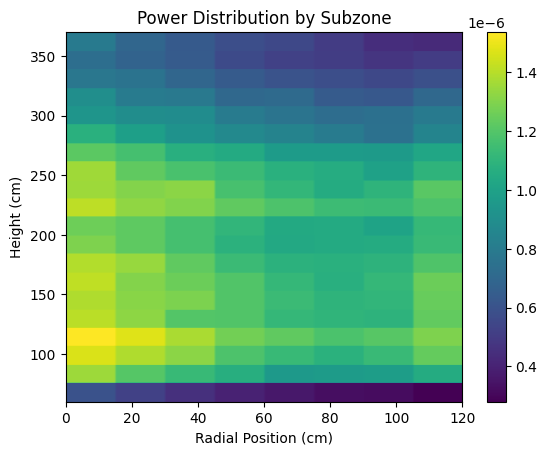

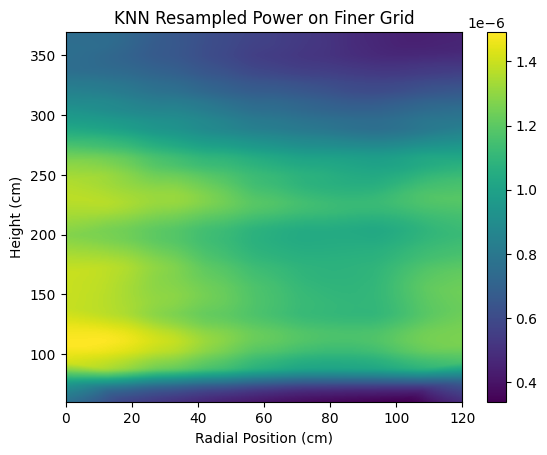

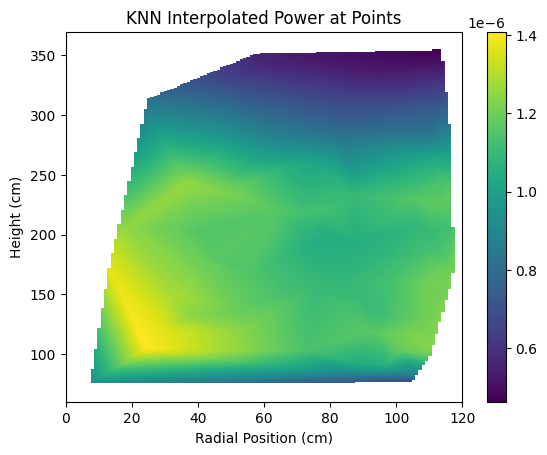

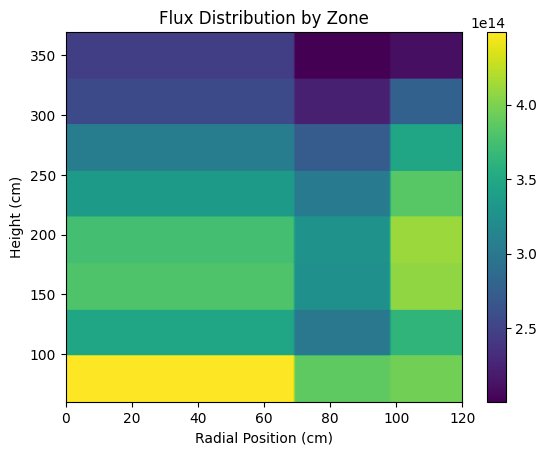

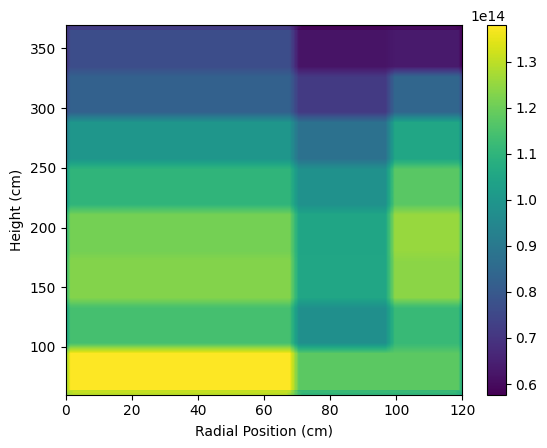

/global/scratch/users/ikolaja/PEARLSim_dev/PEARLSim/pearlsim/ml_utilities.py:442: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_plot_df["energy"] = group_energy


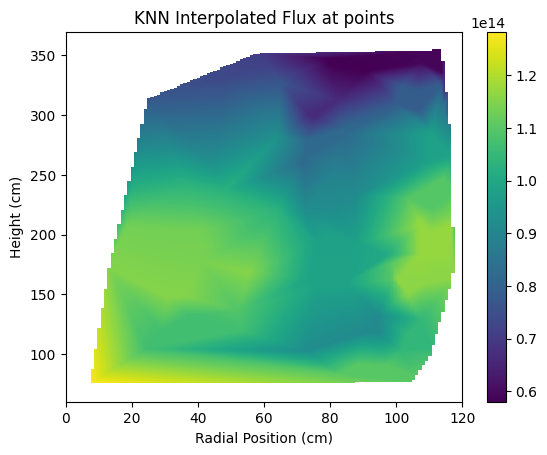

In [109]:
position_after_df, conc_zone_final_df, bumat_dict_final = extract_mesh_data(positions, raw_positions, 490, 2)

In [110]:
predicted_flux_series_1_list = []

for i in range(num_samples):
    start_ind = i*56
    end_ind = (i+1)*56
    current_chunk = position_after_df.iloc[start_ind:end_ind].reset_index(drop=True)
    current = current_model.predict(current_chunk)


    conc_series = conc_post_burn_df[flux_nuclide_labels].iloc[i]
    flux_feature_list = []
    for e in range(len(current)):
        row = conc_series.copy()
        row["energy"] = current_chunk["energy"].iloc[e]
        row["current"] = current[e]
        flux_feature_list += [row]
    flux_features = pd.DataFrame(flux_feature_list).reset_index(drop=True)
    flux = flux_model.predict(flux_features)*np.diff(ENERGY_GRID_56)*PEBBLE_KERNEL_VOLUME

    predicted_flux_series_1_list += [flux]



In [111]:
flux_1_df = pd.DataFrame(predicted_flux_series_1_list)
flux_1_df.columns=xs_models.input_column_labels

predicted_xs_1_list = []
for reaction_key in xs_models.reaction_keys:
    predicted_xs_1_list += [xs_models.predict(flux_1_df, reaction_key)]

xs_predicted_1_df = pd.concat(predicted_xs_1_list, axis=1)
total_flux_1_series = xs_predicted_1_df.pop("total_flux")


In [112]:
avg_flux_list = np.array(total_flux_1_series)/2 + np.array(total_flux_series)/2
total_avg_flux_series = pd.Series(avg_flux_list, name="total_flux")

In [113]:
total_flux_series

0     6.648746e+16
1     5.515443e+16
2     2.204173e+16
3     4.462892e+16
4     5.080228e+16
          ...     
95    4.317374e+16
96    3.761073e+16
97    4.728136e+16
98    4.746420e+16
99    6.121790e+16
Name: total_flux, Length: 100, dtype: float64

In [114]:
total_flux_1_series

0     6.588808e+16
1     5.986733e+16
2     2.270709e+16
3     4.522647e+16
4     5.713259e+16
          ...     
95    4.402998e+16
96    4.098343e+16
97    4.871860e+16
98    4.863026e+16
99    6.007831e+16
Name: total_flux, Length: 100, dtype: float64

In [115]:
xs_predicted_avg_df = xs_predicted_1_df/2 + xs_predicted_df/2
xs_avg_df, rename_map_xs = nuclide_labels_serpent_to_openMC(xs_predicted_avg_df)
display(xs_avg_df.iloc[-5:])
microXS_avg_list = create_MicroXS_batch(xs_avg_df, chain, nuclide_df.columns.to_list())

,Xe133-16,Xe134-17,U240-102,Zr95-107,Xe130-102,Pa232-17,Ru103-102,Sm151-17,Br81-102,U235-16,...,Ba134-17,Ce140-103,Cs136-103,Sr86-102,Pm147-17,Sr89-102,Pm147-103,Cs136-102,Dy158-107,Sr88-107
95,0.000008,3.715539e-11,0.503013,5.940431e-10,0.008509,2.898170e-08,0.025121,1.075907e-09,0.018287,0.000009,...,1.936278e-10,9.411821e-10,1.015204e-09,0.002876,2.802331e-09,0.000723,1.607539e-09,0.036430,5.259559e-09,2.375643e-11
96,0.000010,5.566220e-11,0.489800,6.606828e-10,0.008706,2.982152e-08,0.024817,2.122098e-09,0.017954,0.000011,...,1.030980e-09,1.052135e-09,1.049261e-09,0.002880,2.743621e-09,0.000732,1.657131e-09,0.036635,6.283698e-09,2.827648e-11
97,0.000009,1.141722e-10,0.503494,6.037886e-10,0.008294,3.071336e-08,0.026308,1.321109e-09,0.021566,0.000010,...,7.125518e-10,1.122741e-09,9.773283e-10,0.002838,4.126603e-09,0.000667,1.517866e-09,0.035462,5.501871e-09,3.116162e-11
98,0.000009,9.479796e-11,0.512009,6.298147e-10,0.008202,3.061340e-08,0.026901,9.482971e-10,0.021804,0.000010,...,6.994833e-10,1.106091e-09,9.755400e-10,0.002818,4.802432e-09,0.000663,1.489714e-09,0.035225,5.536333e-09,3.030878e-11
99,0.000009,1.305675e-10,0.537932,6.906983e-10,0.007936,3.682444e-08,0.028105,1.516791e-09,0.021818,0.000010,...,6.005963e-10,1.285059e-09,1.119949e-09,0.002804,4.296744e-09,0.000657,1.622675e-09,0.034431,6.160550e-09,3.648865e-11


Skipping Pm148_m1...
Skipping Ag110_m1...
Skipping Pm148_m1...
Skipping Ag110_m1...
Skipping Pm148_m1...
Skipping Ag110_m1...
Skipping Pm148_m1...
Skipping Ag110_m1...
Skipping Ag110_m1...
Skipping Pm148_m1...


In [116]:
time_start = time.time()
CRAM_func = openmc.deplete.cram.CRAM48

material_collection = openmc.Materials()
total_flux_list = []
material_xs_list = []
total_atom_list = []
n_0_conditions = []
n_f_results = []

for i in range(num_samples):
    nuclides = nuclide_df.iloc[i].to_dict()
    total_flux_list += [total_avg_flux_series[i]]
    total_atom_list += [sum(nuclides.values())]
    material_xs_list += [microXS_avg_list[index]]


    openmc_material = openmc.Material(material_id=i)
    openmc_material.add_components(nuclides, "ao")
    openmc_material.set_density('atom/b-cm', total_atom_list[-1])
    openmc_material.volume = PEBBLE_KERNEL_VOLUME
    material_collection.append(openmc_material)

max_flux = np.max(total_flux_list)
#relative_flux_list = np.array(total_flux_list)/max_flux


depleter = openmc.deplete.IndependentOperator(material_collection, 
                                              total_flux_list,
                                              material_xs_list, 
                                              chain_file="pearlsim_chain.xml",
                                              normalization_mode="source-rate")

n_0 = depleter.initial_condition()
n_0_conditions += [n_0]
res = depleter(n_0, 1)
rates = res.rates
np.shape(rates)

print(f"Depletion {i}")
n_f_results += [openmc.deplete.pool.deplete(CRAM_func, serpent_chain, n_0, rates, 6.525*86400)]
time_end = time.time()
print(f"Finished in {time_end-time_start}")

Depletion 99
Finished in 82.29391646385193


In [117]:
uind = serpent_chain.nuclide_dict["U235"]

In [118]:
sample_index = 1
print(f"Individual pebble: {n_f_results[0][sample_index][uind]*1e-24/PEBBLE_KERNEL_VOLUME}")
print(f"Zone Material:     {conc_zone_final_df['92235<lib>'].iloc[sample_index]}")

Individual pebble: 0.0018860638538277666
Zone Material:     0.00199470142015227


In [119]:
ind_vals = []
zone_vals = []
for i in range(num_samples):
    ind_vals += [n_f_results[0][i][uind]*1e-24/PEBBLE_KERNEL_VOLUME]
    zone_vals += [conc_zone_final_df['92235<lib>'].iloc[i]]
ind_counts, bin_edges = np.histogram(ind_vals, bins=30)

In [120]:
ind_counts, bin_edges = np.histogram(ind_vals, bins=30)
#zone_counts, _ = np.histogram(zone_vals, bins=bin_edges)

In [121]:
ind_vals

[0.0013733150197822927,
 0.0018860638538277666,
 0.0016359678363264494,
 0.0007480935071658137,
 0.004246498185253,
 0.0014259002976027219,
 0.0012687065449904183,
 0.002966321973571875,
 0.0009999141763964397,
 0.0026181840236433763,
 0.0013535246348093412,
 0.0009500040123419041,
 0.0011700163164979874,
 0.003031088743655374,
 0.0036368146358244,
 0.001553815457020751,
 0.001012654420921398,
 0.0029533743835840776,
 0.0006806686552122953,
 0.0007465764303404156,
 0.0009293523023551727,
 0.003120335717975079,
 0.0042016766502142805,
 0.0009342545932913051,
 0.0027496850733621458,
 0.0014248393996140903,
 0.0014613991138374145,
 0.0017129392197631865,
 0.0011765312031984695,
 0.000812636208304928,
 0.00163200580668916,
 0.004155898081040098,
 0.0034027232963498677,
 0.002212167496983172,
 0.0016184013519088987,
 0.0009310725810068321,
 0.001355042863502138,
 0.001107500481816747,
 0.004258143376870173,
 0.0007498051493677288,
 0.0038835512831236754,
 0.0025711370637690437,
 0.000926791

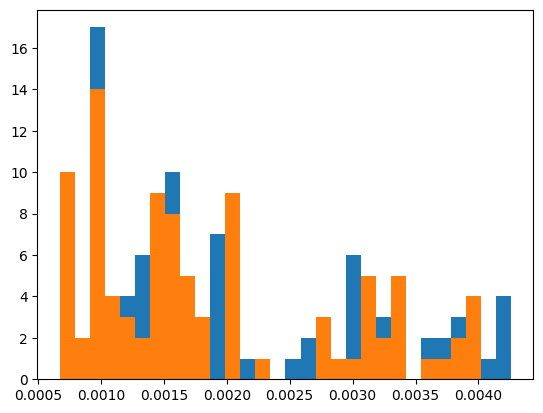

In [122]:
plt.figure()
plt.hist(ind_vals, bin_edges)
plt.hist(zone_vals, bin_edges)
plt.show()

In [24]:
uind = serpent_chain.nuclide_dict["U235"]
xs_uind = material_xs_list[0].nuclides.index("U235")

In [25]:
material_xs_list[0].data[xs_uind]

array([1.71580931e-01, 8.69017045e-06, 0.00000000e+00, 0.00000000e+00,
       3.24744185e-09, 9.88182680e-12, 7.61963258e-01])

In [26]:
nuclides["U235"]*1e-24*PEBBLE_KERNEL_VOLUME*material_xs_list[0].data[uind][6]*total_flux_list[-1]

1.0275080475806986e-10

In [27]:
sample_index = 0
conc_final_df["universe"].iloc[sample_index]

'ufuel20_R1Z3G8'

In [28]:
key = "ufuel20R1Z3G8"

In [29]:
n_0_conditions[0][sample_index][uind]*1e-24/PEBBLE_KERNEL_VOLUME

0.0015048026909136004

In [30]:
conc_df["92235<lib>"].iloc[sample_index]

0.0015048026909136

In [31]:
n_f_results[0][sample_index][uind]*1e-24/PEBBLE_KERNEL_VOLUME

0.0013772156870603437

In [14]:
(n_f_results[0][sample_index][uind]*1e-24/PEBBLE_KERNEL_VOLUME)/(n_0_conditions[0][sample_index][uind]*1e-24/PEBBLE_KERNEL_VOLUME)

NameError: name 'n_f_results' is not defined

In [44]:
conc_final_df["92235<lib>"].iloc[sample_index]

0.00145957124434823

In [45]:
len(n_0_conditions[0][0])

1324

In [39]:
time_start = time.time()
CRAM_func = openmc.deplete.cram.CRAM48
n_0_conditions = []
n_f_results = []

for i in range(1):
    nuclides = nuclide_df.iloc[i].to_dict()
    flux = total_flux_series[i]
    total_atoms = [sum(nuclides.values())]
    material_xs = microXS_list[index]
    depleter = openmc.deplete.IndependentOperator.from_nuclides(PEBBLE_KERNEL_VOLUME, nuclides, 1.0, 
                                                                material_xs, chain_file="pearlsim_chain.xml", nuc_units='atom/b-cm',
                                                               normalization_mode="fission-q")

    n_0 = depleter.initial_condition()
    n_0_conditions += [n_0]
    res = depleter(n_0, flux)
    rates = res.rates
    np.shape(rates)

    print(f"Depletion {i}")
    n_f_results += [openmc.deplete.pool.deplete(CRAM_func, serpent_chain, n_0, rates, 6.525*86400)]
time_end = time.time()
print(f"Finished in {time_end-time_start}")

Depletion 0
Finished in 9.546326160430908


In [88]:
uind = serpent_chain.nuclide_dict["U235"]
n_0[0][uind]

8.209066969257109e+20

In [59]:
nuclide_df.iloc[0].get_loc("U235")

AttributeError: 'Series' object has no attribute 'get_loc'

In [45]:
np.where(n_0[0] == nuclide_df["U235"].iloc[0])

(array([], dtype=int64),)

In [53]:
nuclide_df["U235"].iloc[0]*1e24

1.5048026909136e+21

In [52]:
n_0[0][uind]

3693.37567723092

In [54]:
np.where(n_0[0] == nuclide_df["U235"].iloc[0]*1e24)

(array([], dtype=int64),)

In [47]:
n_f_results[0][0][uind]

4.580563453451461e-09

In [123]:
nuclide_labels = nuclide_df.columns.to_list() 
uind = nuclide_labels.index("U235")
n_f_results[0][0][uind]

0.0

In [63]:
nuclide_df["Ag210_m1"]

KeyError: 'Ag210_m1'

OpenMC Attempted XS Calculations

In [9]:
import openmc
import openmc.deplete
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
import os
import time
import re
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone
from scipy.interpolate import griddata
from pearlsim.ml_utilities import *
from pearlsim.results_processing import read_core_flux
import pickle
from sklearn.neighbors import KNeighborsRegressor
import os.path
train_split = 0.8
openmc.config['cross_sections'] = "/global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/cross_sections.xml"

In [ ]:
key = "962470-102"
xs_features = pd.read_csv(f"training_data/xs_data_{key}.csv.gz", index_col=0)
xs_target =  pd.read_csv(f"training_data/xs_targets_{key}.csv.gz", index_col=0)

xs_std_data = create_training_split(xs_features, 
                                         xs_target, 
                                         train_split, 
                                         log_scale_features="all",
                                         seed=42)
best_params = {'max_depth': 20, 
               'n_estimators': 1000, 
               'n_jobs': 110,} # Set to your number of cores
xs_rfr_model = RandomForestRegressor(random_state=0)
xs_rfr_model.set_params(**best_params)
xs_rfr_model.fit(xs_std_data["training_features"], xs_std_data["training_target"]["xs"].ravel())
xs_rfr_score = xs_rfr_model.score(xs_std_data["testing_features"], xs_std_data["testing_target"]["xs"].ravel())
print(f"{key} cross section RFR score: {xs_rfr_score} - {len(xs_target)} samples")

In [6]:

chain_file = "/global/home/users/ikolaja/openmc_data_old/chain_endfb71_pwr.xml"
chain = openmc.deplete.Chain.from_xml(chain_file)
MTS = [102, 16, 103, 107, 17, 37, 18]

In [27]:
xs_features.iloc[0].to_numpy()

array([4.70194e+09, 3.06891e+10, 1.88785e+11, 2.88626e+11, 2.43222e+11,
       2.60921e+11, 5.59552e+11, 5.65236e+11, 1.27889e+12, 9.68532e+11,
       6.72375e+11, 6.07838e+11, 1.30031e+11, 1.03734e+11, 2.05951e+11,
       1.87530e+11, 1.15814e+11, 1.29691e+10, 8.50248e+09, 2.50000e+11,
       3.50602e+10, 5.57250e+09, 4.46404e+09, 2.71337e+09, 1.72877e+11,
       2.79259e+09, 3.90991e+09, 8.24489e+10, 3.16799e+09, 9.06411e+10,
       5.34154e+09, 6.55760e+10, 5.70060e+09, 1.65766e+10, 1.60690e+09,
       7.73896e+10, 2.97332e+09, 4.18205e+11, 8.58330e+10, 2.65443e+11,
       2.94243e+10, 1.66553e+11, 2.62670e+11, 5.24578e+10, 3.88011e+10,
       9.40394e+10, 8.62386e+10, 9.00197e+10, 5.98757e+10, 1.54201e+11,
       1.09241e+11, 1.09943e+11, 2.28991e+11, 1.10690e+11, 5.90560e+10,
       1.55522e+10])

In [28]:
xs_features.iloc[0].to_numpy().reshape([0,56])

ValueError: cannot reshape array of size 56 into shape (0,56)

In [ ]:
ENERGY_GRID_56*1e6

In [30]:
xs_ex = openmc.deplete.MicroXS.from_multigroup_flux(ENERGY_GRID_56*1e6,
                                            xs_features.iloc[0].to_numpy(),
                                            chain_file="pearlsim_chain.xml", 
                                            temperature=959)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Se80 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Se80.h5
 Reading Se82 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Se82.h5
 Reading Br79 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Br79.h5
 Reading Br81 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Br81.h5
 Reading Kr78 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Kr78.h5
 Reading Kr80 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Kr80.h5
 Reading Kr82 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Kr82.h5
 Reading Kr83 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Kr83.h5
 Reading Kr84 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Kr84.h5
 Reading Kr85 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Kr85.h5
 Reading Kr86 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Kr86.h5
 Reading Rb85 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Rb85.h5
 Rea

 Reading Nb95 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Nb95.h5


 Reading Mo92 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Mo92.h5
 Reading Mo94 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Mo94.h5
 Reading Mo95 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Mo95.h5
 Reading Mo96 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Mo96.h5
 Reading Mo97 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Mo97.h5
 Reading Mo98 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Mo98.h5
 Reading Mo99 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Mo99.h5


 Reading Mo100 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Mo100.h5
 Reading Tc99 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Tc99.h5
 Reading Ru96 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Ru96.h5
 Reading Ru98 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Ru98.h5
 Reading Ru99 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Ru99.h5
 Reading Ru100 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Ru100.h5
 Reading Ru101 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Ru101.h5
 Reading Ru102 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Ru102.h5
 Reading Ru103 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Ru103.h5
 Reading Ru104 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Ru104.h5
 Reading Ru105 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Ru105.h5
 Reading Ru106 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hd

 Reading Cd108 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Cd108.h5
 Reading Cd110 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Cd110.h5
 Reading Cd111 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Cd111.h5
 Reading Cd112 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Cd112.h5
 Reading Cd113 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Cd113.h5
 Reading Cd114 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Cd114.h5
 Reading Cd115_m1 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Cd115_m1.h5
 Reading Cd116 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Cd116.h5
 Reading In113 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/In113.h5
 Reading In115 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/In115.h5
 Reading Sn112 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Sn112.h5
 Reading Sn113 from
 /global/home/groups/co_nuclear/openmc-

 Reading Sn124 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Sn124.h5
 Reading Sn125 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Sn125.h5
 Reading Sn126 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Sn126.h5
 Reading Sb121 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Sb121.h5
 Reading Sb123 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Sb123.h5
 Reading Sb124 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Sb124.h5
 Reading Sb125 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Sb125.h5
 Reading Sb126 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Sb126.h5
 Reading Te120 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Te120.h5
 Reading Te122 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Te122.h5
 Reading Te123 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Te123.h5
 Reading Te124 from
 /global/home/groups/co_nuclear/openmc-lib/en

 Reading I135 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/I135.h5
 Reading Xe123 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Xe123.h5
 Reading Xe124 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Xe124.h5
 Reading Xe126 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Xe126.h5
 Reading Xe128 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Xe128.h5
 Reading Xe129 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Xe129.h5
 Reading Xe130 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Xe130.h5
 Reading Xe131 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Xe131.h5
 Reading Xe132 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Xe132.h5
 Reading Xe133 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Xe133.h5
 Reading Xe134 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Xe134.h5
 Reading Xe135 from
 /global/home/groups/co_nuclear/openmc-lib/endf

 Reading Cs137 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Cs137.h5
 Reading Ba130 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Ba130.h5
 Reading Ba132 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Ba132.h5
 Reading Ba133 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Ba133.h5
 Reading Ba134 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Ba134.h5
 Reading Ba135 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Ba135.h5
 Reading Ba136 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Ba136.h5
 Reading Ba137 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Ba137.h5
 Reading Ba138 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Ba138.h5
 Reading Ba140 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Ba140.h5
 Reading La138 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/La138.h5
 Reading La139 from
 /global/home/groups/co_nuclear/openmc-lib/en

 Reading Gd152 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Gd152.h5
 Reading Gd153 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Gd153.h5
 Reading Gd154 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Gd154.h5
 Reading Gd155 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Gd155.h5
 Reading Gd156 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Gd156.h5
 Reading Gd157 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Gd157.h5
 Reading Gd158 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Gd158.h5
 Reading Gd160 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Gd160.h5
 Reading Tb159 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Tb159.h5
 Reading Tb160 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Tb160.h5
 Reading Dy156 from
 /global/home/groups/co_nuclear/openmc-lib/endfb71_hdf5/Dy156.h5
 Reading Dy158 from
 /global/home/groups/co_nuclear/openmc-lib/en

 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...


ArgumentError: argument 5: TypeError: array must have flags ['C_CONTIGUOUS']

In [60]:


sample =  pd.read_csv(f"training_data/xs_targets_total_flux.csv.gz", index_col=0)



Microscopic cross section data for use in transport-independent depletion.

New in version 0.13.1.

Changed in version 0.14.0: Class was heavily refactored and no longer subclasses pandas.DataFrame.

Parameters
data (numpy.ndarray of floats) – 3D array containing microscopic cross section values for each nuclide, reaction, and energy group. Cross section values are assumed to be in [b], and indexed by [nuclide, reaction, energy group]

nuclides (list of str) – List of nuclide symbols for that have data for at least one reaction.

reactions (list of str) – List of reactions. All reactions must match those in openmc.deplete.chain.REACTIONS

# LEGACY

In [ ]:
index = 0
nuclides = nuclide_df.iloc[index].to_dict()
material_xs = microXS_list[index]
flux = total_flux_series[index]
total_atoms = [sum(nuclides.values())]
depleter = openmc.deplete.IndependentOperator.from_nuclides(PEBBLE_KERNEL_VOLUME, nuclides, 1.0, 
                                                            material_xs, chain_file="pearlsim_chain.xml", 
                                                            nuc_units='atom/b-cm',
                                                            normalization_mode="srcrate")

print("Starting integration...")
openmc.deplete.CECMIntegrator(depleter, [6.525], source_rates = flux,  timestep_units="d", solver="cram48").integrate(path = 'depletion_results_2.h5')


In [153]:
all_features.drop(columns=["radius","height"]).iloc[7*4000+1]

index          0.000000e+00
cs137          9.529456e-05
xe135          1.481146e-08
u235           1.138590e-03
binR1Z1E1      2.648924e+20
                   ...     
binR4Z9E18     1.154314e+12
binR1Z10E18    1.233549e+12
binR2Z10E18    1.158767e+12
binR3Z10E18    9.428232e+11
binR4Z10E18    6.635591e+11
Name: 28000, Length: 724, dtype: float64

In [63]:
features

,radius,height
0,0.000000,60.00
1,1.008403,60.00
2,2.016807,60.00
3,3.025210,60.00
4,4.033613,60.00
...,...,...
31195,115.966387,369.47
31196,116.974790,369.47
31197,117.983193,369.47
31198,118.991597,369.47


In [174]:
plot_radius = np.arange(0,120,0.5)
plot_height = np.arange(60,370,0.5)
grid_radius, grid_height = np.meshgrid(plot_radius, plot_height)
num_points = len(plot_radius)*len(plot_height)
constants = all_features.drop(columns=["radius","height"]).iloc[7*4000+2]
plot_grid = pd.DataFrame({"radius":grid_radius.flatten(),"height":grid_height.flatten()})
for feature in constants.keys():
    plot_grid[feature] = constants[feature]

display(plot_grid)

,radius,height,cs137,xe135,u235,binR1Z1E1,binR2Z1E1,binR3Z1E1,binR4Z1E1,binR1Z2E1,...,binR3Z8E18,binR4Z8E18,binR1Z9E18,binR2Z9E18,binR3Z9E18,binR4Z9E18,binR1Z10E18,binR2Z10E18,binR3Z10E18,binR4Z10E18
0,0.0,60.0,0.000079,2.174626e-08,0.001735,2.648924e+20,2.435903e+20,2.092314e+20,1.741044e+20,3.646944e+20,...,1.611570e+12,1.195377e+12,1.986022e+12,1.840819e+12,1.578203e+12,1.154314e+12,1.233549e+12,1.158767e+12,9.428232e+11,6.635591e+11
1,0.5,60.0,0.000079,2.174626e-08,0.001735,2.648924e+20,2.435903e+20,2.092314e+20,1.741044e+20,3.646944e+20,...,1.611570e+12,1.195377e+12,1.986022e+12,1.840819e+12,1.578203e+12,1.154314e+12,1.233549e+12,1.158767e+12,9.428232e+11,6.635591e+11
2,1.0,60.0,0.000079,2.174626e-08,0.001735,2.648924e+20,2.435903e+20,2.092314e+20,1.741044e+20,3.646944e+20,...,1.611570e+12,1.195377e+12,1.986022e+12,1.840819e+12,1.578203e+12,1.154314e+12,1.233549e+12,1.158767e+12,9.428232e+11,6.635591e+11
3,1.5,60.0,0.000079,2.174626e-08,0.001735,2.648924e+20,2.435903e+20,2.092314e+20,1.741044e+20,3.646944e+20,...,1.611570e+12,1.195377e+12,1.986022e+12,1.840819e+12,1.578203e+12,1.154314e+12,1.233549e+12,1.158767e+12,9.428232e+11,6.635591e+11
4,2.0,60.0,0.000079,2.174626e-08,0.001735,2.648924e+20,2.435903e+20,2.092314e+20,1.741044e+20,3.646944e+20,...,1.611570e+12,1.195377e+12,1.986022e+12,1.840819e+12,1.578203e+12,1.154314e+12,1.233549e+12,1.158767e+12,9.428232e+11,6.635591e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148795,117.5,369.5,0.000079,2.174626e-08,0.001735,2.648924e+20,2.435903e+20,2.092314e+20,1.741044e+20,3.646944e+20,...,1.611570e+12,1.195377e+12,1.986022e+12,1.840819e+12,1.578203e+12,1.154314e+12,1.233549e+12,1.158767e+12,9.428232e+11,6.635591e+11
148796,118.0,369.5,0.000079,2.174626e-08,0.001735,2.648924e+20,2.435903e+20,2.092314e+20,1.741044e+20,3.646944e+20,...,1.611570e+12,1.195377e+12,1.986022e+12,1.840819e+12,1.578203e+12,1.154314e+12,1.233549e+12,1.158767e+12,9.428232e+11,6.635591e+11
148797,118.5,369.5,0.000079,2.174626e-08,0.001735,2.648924e+20,2.435903e+20,2.092314e+20,1.741044e+20,3.646944e+20,...,1.611570e+12,1.195377e+12,1.986022e+12,1.840819e+12,1.578203e+12,1.154314e+12,1.233549e+12,1.158767e+12,9.428232e+11,6.635591e+11
148798,119.0,369.5,0.000079,2.174626e-08,0.001735,2.648924e+20,2.435903e+20,2.092314e+20,1.741044e+20,3.646944e+20,...,1.611570e+12,1.195377e+12,1.986022e+12,1.840819e+12,1.578203e+12,1.154314e+12,1.233549e+12,1.158767e+12,9.428232e+11,6.635591e+11


In [175]:
std_plot_data, _, _  = standardize(plot_grid, mean=data_mean, std=data_std)
predicted_currents_stan = pd.DataFrame(rfr_model.predict(std_plot_data),columns=target_mean.keys())
predicted_currents = unstandardize(predicted_currents_stan, target_mean, target_std)
predicted_currents

,2.9005e-08,9.9e-08,2.1e-07,4.525e-07,7.985000000000001e-07,1.061e-06,1.5025e-06,2.9275e-06,6.9385e-06,1.29225e-05,8.234799999999999e-05,0.002839364,0.007324,0.060059,0.3055,0.6605,1.5259999999999998,6.1155,power
0,1.263647e+15,2.871676e+15,2.869039e+15,1.439584e+15,2.681861e+14,7.987940e+13,2.248350e+14,3.422306e+14,4.123560e+14,2.242552e+14,1.140145e+15,1.989796e+15,2.849299e+14,1.448902e+15,6.571449e+14,3.117875e+14,5.585981e+14,2.099302e+14,4378.375474
1,1.263647e+15,2.871676e+15,2.869039e+15,1.439584e+15,2.681861e+14,7.987940e+13,2.248350e+14,3.422306e+14,4.123560e+14,2.242552e+14,1.140145e+15,1.989796e+15,2.849299e+14,1.448902e+15,6.571449e+14,3.117875e+14,5.585981e+14,2.099302e+14,4378.375474
2,1.263647e+15,2.871676e+15,2.869039e+15,1.439584e+15,2.681861e+14,7.987940e+13,2.248350e+14,3.422306e+14,4.123560e+14,2.242552e+14,1.140145e+15,1.989796e+15,2.849299e+14,1.448902e+15,6.571449e+14,3.117875e+14,5.585981e+14,2.099302e+14,4378.375474
3,1.263647e+15,2.871676e+15,2.869039e+15,1.439584e+15,2.681861e+14,7.987940e+13,2.248350e+14,3.422306e+14,4.123560e+14,2.242552e+14,1.140145e+15,1.989796e+15,2.849299e+14,1.448902e+15,6.571449e+14,3.117875e+14,5.585981e+14,2.099302e+14,4378.375474
4,1.263647e+15,2.871676e+15,2.869039e+15,1.439584e+15,2.681861e+14,7.987940e+13,2.248350e+14,3.422306e+14,4.123560e+14,2.242552e+14,1.140145e+15,1.989796e+15,2.849299e+14,1.448902e+15,6.571449e+14,3.117875e+14,5.585981e+14,2.099302e+14,4378.375474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148795,1.771917e+14,3.917056e+14,3.727134e+14,1.639614e+14,1.531825e+13,4.140286e+12,1.428259e+13,1.945208e+13,2.211608e+13,1.541826e+13,5.678626e+13,9.852049e+13,1.730570e+13,7.391276e+13,4.587064e+13,1.586934e+13,3.425345e+13,1.370645e+13,478.290418
148796,1.775746e+14,3.926674e+14,3.742234e+14,1.634098e+14,1.530601e+13,4.018922e+12,1.392963e+13,1.919819e+13,2.181399e+13,1.581806e+13,5.641773e+13,9.790659e+13,1.649141e+13,7.332398e+13,4.505300e+13,1.577722e+13,3.352279e+13,1.342556e+13,508.681753
148797,1.775746e+14,3.926674e+14,3.742234e+14,1.634098e+14,1.530601e+13,4.018922e+12,1.392963e+13,1.919819e+13,2.181399e+13,1.581806e+13,5.641773e+13,9.790659e+13,1.649141e+13,7.332398e+13,4.505300e+13,1.577722e+13,3.352279e+13,1.342556e+13,508.681753
148798,1.775746e+14,3.926674e+14,3.742234e+14,1.634098e+14,1.530601e+13,4.018922e+12,1.392963e+13,1.919819e+13,2.181399e+13,1.581806e+13,5.641773e+13,9.790659e+13,1.649141e+13,7.332398e+13,4.505300e+13,1.577722e+13,3.352279e+13,1.342556e+13,508.681753


In [135]:
std_current = rfr_model.predict(training_data)
std_current = pd.DataFrame({"current_E1": std_current})
predicted_currents = unstandardize(std_current, target_mean, target_std)

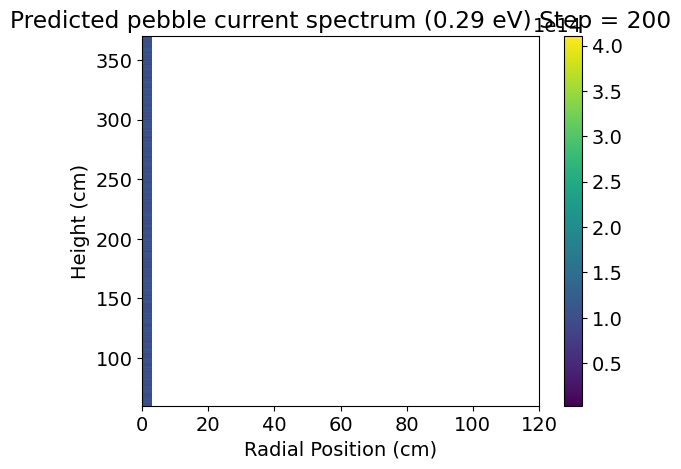

In [138]:
plot_target = predicted_currents.to_numpy()
plt.imshow(np.rot90(plot_target,1), extent=(0,120,60,370), aspect='auto')
plt.title(f"Predicted pebble current spectrum (0.29 eV) Step = 200")
plt.xlabel("Radial Position (cm)")
plt.ylabel("Height (cm)")
plt.colorbar()

In [102]:
ENERGY_BINS = np.array([1.00000e-11, 2.50000e-08, 5.80000e-08, 1.80000e-07, 3.20000e-07, 7.80000e-07, 
                       9.96000e-07, 1.12300e-06, 2.10000e-06, 1.59680e-05, 3.67262e-04, 5.50000e-03,
                       6.74300e-02, 8.21000e-01, 2.00000e+01])
RADIUS_BINS = np.linspace(0, 120, 4+1)
HEIGHT_BINS = np.flip(np.linspace(60, 369.47, 10+1))
ENERGY_CENTERS = (ENERGY_BINS[1:] + ENERGY_BINS[:-1])/2


def read_det_file(file_name, map_name="zone_14group_flux", read_pebbles=False, series_label="bin"):
    reading=False
    energy_centers = ENERGY_CENTERS
    skip_names = ["E", "PHI", "Z", "R"]
    id_array = []
    x_array = []
    y_array = []
    z_array = []
    pebble_flux_matrix = []
    core_flux_headers = []
    flattened_flux = []
    if "power" in map_name:
        core_flux = np.zeros( (len(RADIUS_BINS)-1, len(HEIGHT_BINS)-1, 1 ) )
    else:
        core_flux = np.zeros( (len(RADIUS_BINS)-1, len(HEIGHT_BINS)-1, len(ENERGY_BINS)-1 ) )
    with open(file_name, 'r') as f:
        for line in f:
            line = line.replace("DET","")
            if "power" in line or "flux" in line or "peb" in line:
                if not any([x in line for x in skip_names]):
                    reading = True
                    data_array = []
                    unc_array = []
                    if "peb" in line:
                        header = line.split("_")
                        id_array += [int(header[1])]
                        x_array += [float(header[2])]
                        y_array += [float(header[3])]
                        z_array += [float(header[4])]
                        set_name = "peb"
                    else:
                        set_name = line.split()[0]
            elif "]" in line and reading:
                reading = False
                if set_name == "peb":
                    pebble_flux_matrix += [data_array]
            elif reading:
                line = line.split()
                if set_name == "peb":
                    data = float(line[10])
                    unc = float(line[11])
                    data_array += [data]
                    unc_array += [unc]
                elif map_name in set_name:
                    bin_e = int(line[1])-1
                    bin_r = int(line[9])-1
                    bin_z = int(line[7])-1
                    data = float(line[10])
                    volume = np.pi*(RADIUS_BINS[bin_r+1]**2-RADIUS_BINS[bin_r]**2)*(HEIGHT_BINS[bin_z]-HEIGHT_BINS[bin_z+1])
                    energy_width = ENERGY_BINS[bin_e+1]-ENERGY_BINS[bin_e]
                    core_flux[bin_r, bin_z, bin_e] = data/volume/(energy_width*1e6)
                    flattened_flux += [data/volume/(energy_width*1e6)]
                    core_flux_headers += [f"{series_label}R{bin_r+1}Z{bin_z+1}E{bin_e+1}"]

    pebble_flux_matrix = np.array(pebble_flux_matrix)
    core_flux_series = pd.Series(data=flattened_flux, index=core_flux_headers)
           
    if read_pebbles:
        features = pd.DataFrame({"x": x_array, "y": y_array, "z": z_array })
        num_detectors = len(features)
        targets = pd.DataFrame(pebble_flux_matrix, columns=energy_centers)
        avg_uncertainty = np.mean(np.array(unc_array))
        return features, targets, core_flux, core_flux_series, avg_uncertainty, id_array
    
    else: 
        return core_flux, core_flux_series

In [103]:
core_flux, core_flux_series = read_det_file("gFHR_sequence/gFHR_equilibrium_200.serpent_det2.m", map_name="14group_flux")

In [104]:
core_flux_series

binR1Z1E1      9.222416e+13
binR2Z1E1      9.447236e+13
binR3Z1E1      8.173245e+13
binR4Z1E1      7.908613e+13
binR1Z2E1      7.216462e+13
                   ...     
binR4Z9E14     1.765372e+06
binR1Z10E14    1.667330e+06
binR2Z10E14    1.583688e+06
binR3Z10E14    1.342340e+06
binR4Z10E14    1.046273e+06
Length: 560, dtype: float64

In [105]:
core_flux_series.axes[0][0]

'binR1Z1E1'

[75.5, 75.5, 75.5, 75.5, 106.5, 106.5, 106.5, 106.5, 137.5, 137.5, 137.5, 137.5, 168.5, 168.5, 168.5, 168.5, 199.5, 199.5, 199.5, 199.5, 230.5, 230.5, 230.5, 230.5, 261.5, 261.5, 261.5, 261.5, 292.5, 292.5, 292.5, 292.5, 323.5, 323.5, 323.5, 323.5, 354.5, 354.5, 354.5, 354.5]


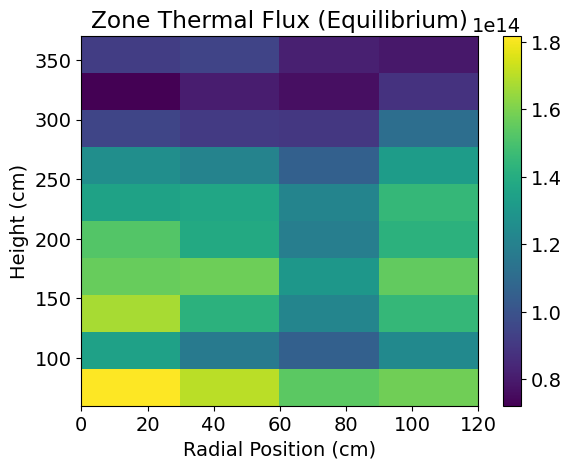

In [106]:
radius_vals = []
height_vals = []
flux_vals = []
radius_bounds = np.linspace(0,120,5)
height_bounds = np.linspace(60,370,11)
desired_E = 1
for column in core_flux_series.axes[0]:
    R = int(column.split("R")[1].split("Z")[0])
    Z = int(column.split("Z")[1].split("E")[0])
    E = int(column.split("E")[1])
    if E == desired_E:
        radius_vals += [ (radius_bounds[R]+radius_bounds[R-1])/2 ]
        height_vals += [ (height_bounds[Z]+height_bounds[Z-1])/2]
        flux_vals += [core_flux_series[column]]

serpent_flux = np.array(flux_vals).reshape(10,4)
#plt.imshow(serpent_flux)
print(height_vals)
plt.rcParams.update({'font.size': 14})
plt.imshow(serpent_flux, extent=(0,120,60,370), aspect='auto')
plt.title(f"Zone Thermal Flux (Equilibrium)")
plt.xlabel("Radial Position (cm)")
plt.ylabel("Height (cm)")
plt.colorbar()

In [33]:
constants.loc[constants.index.repeat(1)].reset_index(drop=True)

0      0.000000e+00
1      0.000000e+00
2      4.669530e-03
3      1.013601e+20
4      9.413196e+19
           ...     
718    3.919154e+11
719    3.673934e+11
720    3.373850e+11
721    2.810195e+11
722    2.163722e+11
Name: 0, Length: 723, dtype: float64

In [24]:

def create_MicroXS(xs_df_row, chain, nuclide_labels, replace_keys={}, drop_columns = []):
    reaction_index_key = {"102":0, "16":1, "107":2, "103":3, "17":4, "37":5, "18":6}
    data = np.zeros([len(nuclide_labels), 7, 1])
    for raw_column in xs_df_row.axes[0]:
        nuclide, mt = raw_column.split("-")
        try:
            nuclide_index = nuclide_labels.index(nuclide)
            reaction_index = reaction_index_key[mt]
            data[nuclide_index, reaction_index, 0] = xs_df_row[raw_column]
        except:
            print(f"Skipping {nuclide}...")
    microXS = openmc.deplete.MicroXS(data, nuclide_labels, chain.reactions)
    return microXS
    
sample_microXS = create_MicroXS(xs_df.iloc[0], chain, nuclide_df.columns.to_list())
        
    

,0
cs137,0.000000e+00
xe135,0.000000e+00
u235,4.669530e-03
binR1Z1E1,1.013601e+20
binR2Z1E1,9.413196e+19
...,...
binR4Z9E18,3.919154e+11
binR1Z10E18,3.673934e+11
binR2Z10E18,3.373850e+11
binR3Z10E18,2.810195e+11
